In [1]:
# === Cell 1: Upload the Excel file (Colab) ===
# After running, pick your Hackathon_ERCOT.xlsx from your machine.
from google.colab import files
up = files.upload()  # choose the ERCOT file, e.g., "Hackathon_ERCOT.xlsx"

# Infer path (first uploaded file)
excel_path = list(up.keys())[0]
print("Using file:", excel_path)


Saving Input_Hackathon_ERCOT.xlsx to Input_Hackathon_ERCOT.xlsx
Using file: Input_Hackathon_ERCOT.xlsx


In [2]:
# === Cell 2: ERCOT Step-1 — Audit & Cleaning ===
import pandas as pd
import numpy as np
from pathlib import Path

# -----------------------
# Helpers
# -----------------------
def load_ercot_excel(path: str, sheet_name: str = "ERCOT"):
    """
    Parses the mixed ERCOT sheet layout:
      - Historical table is in first 8 columns with headers on the first row.
      - Forward Prices table starts at column 10 with headers on the first row.
    Returns tidy (hist, fwd) DataFrames.
    """
    raw = pd.read_excel(path, sheet_name=sheet_name)

    # Historical: first 8 columns, header row is row 0
    hist_cols = raw.iloc[0, 0:8].tolist()
    hist = raw.iloc[1:, 0:8].copy()
    hist.columns = [str(c).strip() for c in hist_cols]

    # Some files have trailing space in "Gen "
    if "Gen" not in hist.columns and "Gen " in hist.columns:
        hist.rename(columns={"Gen ": "Gen"}, inplace=True)

    # Forward Prices: columns 10..12 (Date, Peak, Off Peak) per your screenshot
    fwd_cols = raw.iloc[0, 10:13].tolist()
    fwd = raw.iloc[1:, 10:13].copy()
    fwd.columns = [str(c).strip() for c in fwd_cols]

    # Coerce types (history)
    hist["Date"] = pd.to_datetime(hist["Date"], errors="coerce")
    hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
    hist["P/OP"] = hist["P/OP"].astype(str).str.strip()

    for c in ["Gen", "RT Busbar", "RT Hub", "DA Busbar", "DA Hub"]:
        if c not in hist.columns:
            raise ValueError(f"Expected column '{c}' not found in historical block.")
        hist[c] = pd.to_numeric(hist[c], errors="coerce")

    # Coerce types (forwards)
    fwd["Date"] = pd.to_datetime(fwd["Date"], errors="coerce")
    for c in fwd.columns:
        if c != "Date":
            fwd[c] = pd.to_numeric(fwd[c], errors="coerce")

    return hist, fwd

def add_derived_fields(hist: pd.DataFrame) -> pd.DataFrame:
    """
    Adds basis, negative-price flags, Month & peak/off-peak mask.
    """
    out = hist.copy()
    out["RT Basis"] = out["RT Busbar"] - out["RT Hub"]
    out["DA Basis"] = out["DA Busbar"] - out["DA Hub"]
    out["is_peak"]  = out["P/OP"].str.upper().str.startswith("P")
    out["Month"]    = out["Date"].dt.to_period("M")
    out["Neg RT Bus"] = out["RT Busbar"] < 0
    out["Neg DA Bus"] = out["DA Busbar"] < 0
    out["Neg RT Hub"] = out["RT Hub"]   < 0
    out["Neg DA Hub"] = out["DA Hub"]   < 0
    return out

def make_audit_tables(hist: pd.DataFrame):
    """
    Produces:
      - summary_df: date span, counts, negatives, basis stats
      - gen_mpo: monthly generation by (peak/off-peak)
      - corrs: gen–price/basis correlations
      - neg_by_period: negative price frequency by period
      - basis_q: basis quantiles by period (P10..P90)
    """
    # Summary
    summary_df = pd.DataFrame({
        "Start": [hist["Date"].min()],
        "End":   [hist["Date"].max()],
        "Hours": [hist.shape[0]],
        "Peak hours %": [hist["is_peak"].mean()],
        "Mean Gen (MW)": [hist["Gen"].mean()],
        "Neg price freq RT Bus": [hist["Neg RT Bus"].mean()],
        "Neg price freq DA Bus": [hist["Neg DA Bus"].mean()],
        "Neg price freq RT Hub": [hist["Neg RT Hub"].mean()],
        "Neg price freq DA Hub": [hist["Neg DA Hub"].mean()],
        "Mean RT Basis ($/MWh)": [hist["RT Basis"].mean()],
        "P10 RT Basis": [hist["RT Basis"].quantile(0.10)],
        "P25 RT Basis": [hist["RT Basis"].quantile(0.25)],
        "P50 RT Basis": [hist["RT Basis"].quantile(0.50)],
    }).round(3)

    # Monthly gen by peak/off-peak
    gen_mpo = (hist
               .groupby(["Month","is_peak"])["Gen"]
               .sum()
               .unstack(fill_value=0)
               .rename(columns={False:"OffPeak MWh", True:"Peak MWh"})
               .reset_index())
    gen_mpo["Total MWh"] = gen_mpo["OffPeak MWh"] + gen_mpo["Peak MWh"]

    # Correlations
    corrs = pd.DataFrame({
        "Corr(Gen, RT Busbar)": [hist["Gen"].corr(hist["RT Busbar"])],
        "Corr(Gen, RT Hub)":    [hist["Gen"].corr(hist["RT Hub"])],
        "Corr(Gen, DA Busbar)": [hist["Gen"].corr(hist["DA Busbar"])],
        "Corr(Gen, DA Hub)":    [hist["Gen"].corr(hist["DA Hub"])],
        "Corr(Gen, RT Basis)":  [hist["Gen"].corr(hist["RT Basis"])],
        "Corr(Gen, DA Basis)":  [hist["Gen"].corr(hist["DA Basis"])],
    }).round(3)

    # Negative price frequency by period
    neg_by_period = (hist
        .groupby("is_peak")[["Neg RT Bus","Neg DA Bus","Neg RT Hub","Neg DA Hub"]]
        .mean()
        .rename(index={False:"Off-Peak", True:"Peak"})
        .reset_index()
        .rename(columns={"is_peak":"Period"})
        .round(3))

    # Basis quantiles by period
    def q(df, col):
        return pd.Series({
            "P10": df[col].quantile(0.10),
            "P25": df[col].quantile(0.25),
            "P50": df[col].quantile(0.50),
            "P75": df[col].quantile(0.75),
            "P90": df[col].quantile(0.90),
        })
    basis_q = (hist
        .groupby("is_peak")[["RT Basis","DA Basis"]]
        .apply(lambda g: pd.concat([q(g, "RT Basis"), q(g, "DA Basis")], axis=1).T)
        .reset_index())
    basis_q["Period"] = basis_q["is_peak"].map({False:"Off-Peak", True:"Peak"})
    basis_q = basis_q.drop(columns=["is_peak"]).rename(columns={"level_1":"Series"}).round(3)

    return summary_df, gen_mpo, corrs, neg_by_period, basis_q

# -----------------------
# Run Step-1
# -----------------------
hist, fwd = load_ercot_excel(excel_path, sheet_name="ERCOT")
hist = add_derived_fields(hist)

summary_df, gen_mpo, corrs, neg_by_period, basis_q = make_audit_tables(hist)

# Save outputs for next steps
outdir = Path("ercot_step1_outputs")
outdir.mkdir(exist_ok=True, parents=True)
hist.to_csv(outdir / "ercot_history_tidy.csv", index=False)
fwd.to_csv(outdir / "ercot_forwards_tidy.csv", index=False)
summary_df.to_csv(outdir / "ercot_audit_summary.csv", index=False)
gen_mpo.to_csv(outdir / "ercot_monthly_gen_peak_offpeak.csv", index=False)
corrs.to_csv(outdir / "ercot_gen_price_correlations.csv", index=False)
neg_by_period.to_csv(outdir / "ercot_negative_price_by_period.csv", index=False)
basis_q.to_csv(outdir / "ercot_basis_quantiles_by_period.csv", index=False)

print("Saved files:")
for p in sorted(outdir.glob("*.csv")):
    print(" -", p)

# Quick peek
display(summary_df)
display(gen_mpo.head())
display(corrs)
display(neg_by_period)
display(basis_q.head())


Saved files:
 - ercot_step1_outputs/ercot_audit_summary.csv
 - ercot_step1_outputs/ercot_basis_quantiles_by_period.csv
 - ercot_step1_outputs/ercot_forwards_tidy.csv
 - ercot_step1_outputs/ercot_gen_price_correlations.csv
 - ercot_step1_outputs/ercot_history_tidy.csv
 - ercot_step1_outputs/ercot_monthly_gen_peak_offpeak.csv
 - ercot_step1_outputs/ercot_negative_price_by_period.csv


,Start,End,Hours,Peak hours %,Mean Gen (MW),Neg price freq RT Bus,Neg price freq DA Bus,Neg price freq RT Hub,Neg price freq DA Hub,Mean RT Basis ($/MWh),P10 RT Basis,P25 RT Basis,P50 RT Basis
0,2022-01-01,2024-12-31,26304,0.465,20.708,0.172,0.083,0.022,0.002,-11.363,-29.297,-7.229,0.0


is_peak,Month,OffPeak MWh,Peak MWh,Total MWh
0,2022-01,6778.1,5435.1,12213.2
1,2022-02,3602.4,4382.3,7984.7
2,2022-03,5949.4,6088.9,12038.3
3,2022-04,6857.2,5813.1,12670.3
4,2022-05,12504.2,9135.7,21639.9


,"Corr(Gen, RT Busbar)","Corr(Gen, RT Hub)","Corr(Gen, DA Busbar)","Corr(Gen, DA Hub)","Corr(Gen, RT Basis)","Corr(Gen, DA Basis)"
0,0.017,0.082,0.057,0.101,-0.12,-0.215


,Period,Neg RT Bus,Neg DA Bus,Neg RT Hub,Neg DA Hub
0,Off-Peak,0.161,0.078,0.029,0.003
1,Peak,0.186,0.089,0.014,0.000


,Series,P10,P25,P50,P75,P90,Period
0,0,-22.324,-3.156,0.000,0.105,0.982,Off-Peak
1,1,-20.817,-6.230,-0.160,0.130,0.750,Off-Peak
2,0,-37.830,-12.600,-0.008,0.070,1.310,Peak
3,1,-34.891,-15.462,-0.770,0.190,1.490,Peak


In [3]:
import pandas as pd, numpy as np
from pathlib import Path
from dataclasses import dataclass

# Try to read Step-1 outputs; if missing, re-parse Excel
indir = Path("ercot_step1_outputs")

def load_step1_or_excel():
    if (indir / "ercot_history_tidy.csv").exists() and (indir / "ercot_forwards_tidy.csv").exists():
        hist = pd.read_csv(indir / "ercot_history_tidy.csv", parse_dates=["Date"])
        fwd  = pd.read_csv(indir / "ercot_forwards_tidy.csv",  parse_dates=["Date"])
        return hist, fwd
    # Fallback: parse Excel directly (same parsing as Step-1)
    raw = pd.read_excel(excel_path, sheet_name="ERCOT")
    hist_cols = raw.iloc[0, 0:8].tolist()
    hist = raw.iloc[1:, 0:8].copy()
    hist.columns = [str(c).strip() for c in hist_cols]
    if "Gen" not in hist.columns and "Gen " in hist.columns:
        hist.rename(columns={"Gen ": "Gen"}, inplace=True)
    hist["Date"] = pd.to_datetime(hist["Date"], errors="coerce")
    for c in ["HE","Gen","RT Busbar","RT Hub","DA Busbar","DA Hub"]:
        hist[c] = pd.to_numeric(hist[c], errors="coerce")
    hist["P/OP"] = hist["P/OP"].astype(str).str.strip()

    fwd_cols = raw.iloc[0, 10:13].tolist()
    fwd = raw.iloc[1:, 10:13].copy()
    fwd.columns = [str(c).strip() for c in fwd_cols]
    fwd["Date"] = pd.to_datetime(fwd["Date"], errors="coerce")
    for c in fwd.columns:
        if c != "Date":
            fwd[c] = pd.to_numeric(fwd[c], errors="coerce")
    return hist, fwd

hist, fwd = load_step1_or_excel()

# Derived fields (needed for shape learning if we came from Excel)
if "RT Basis" not in hist.columns:
    hist["RT Basis"] = hist["RT Busbar"] - hist["RT Hub"]
    hist["DA Basis"] = hist["DA Busbar"] - hist["DA Hub"]
    hist["Month"]    = hist["Date"].dt.to_period("M")
    hist["is_peak"]  = hist["P/OP"].str.upper().str.startswith("P")

print(hist.head(3))
print(fwd.head(3))


        Date  HE P/OP   Gen  RT Busbar  RT Hub  DA Busbar  DA Hub  RT Basis  \
0 2022-01-01   1   OP  36.8      0.740  56.428       5.20   30.17   -55.688   
1 2022-01-01   2   OP  17.0     -3.782  29.242       1.54   22.08   -33.024   
2 2022-01-01   3   OP  14.6     -4.000  22.145       1.83   19.97   -26.145   

   DA Basis  is_peak    Month  Neg RT Bus  Neg DA Bus  Neg RT Hub  Neg DA Hub  
0    -24.97    False  2022-01       False       False       False       False  
1    -20.54    False  2022-01        True       False       False       False  
2    -18.14    False  2022-01        True       False       False       False  
        Date   Peak  Off Peak
0 2026-01-01  66.41     61.71
1 2026-02-01  66.38     59.84
2 2026-03-01  47.90     37.77


In [4]:
@dataclass
class PeakDef:
    start_he: int = 7     # HE 7...
    end_he: int   = 22    # ...to HE 22 inclusive
    weekdays: set = None  # Mon(0)..Sun(6). Default Mon–Fri (5x16)

    def __post_init__(self):
        if self.weekdays is None:
            self.weekdays = set([0,1,2,3,4])  # Mon–Fri

def is_peak_5x16(ts: pd.Timestamp, peak: PeakDef) -> bool:
    return (ts.weekday() in peak.weekdays) and (peak.start_he <= ts.hour <= peak.end_he)

peakdef = PeakDef()


In [5]:
# Month-of-year & hour index
hist["month_num"] = hist["Date"].dt.month
hist["hour"] = hist["Date"].dt.hour
hist["is_peak_hist"] = hist["P/OP"].str.upper().str.startswith("P")

# Average DA Hub by (month_num, period, hour)
avg_by_mph = (hist.groupby(["month_num","is_peak_hist","hour"])["DA Hub"]
              .mean().rename("mu_mph").reset_index())

# Normalize to mean=1 within each (month_num, period)
mean_by_mp = (avg_by_mph.groupby(["month_num","is_peak_hist"])["mu_mph"]
              .mean().rename("mu_mp").reset_index())

shape = avg_by_mph.merge(mean_by_mp, on=["month_num","is_peak_hist"], how="left")
shape["shape_factor"] = shape["mu_mph"] / shape["mu_mp"]
shape.head(10)


,month_num,is_peak_hist,hour,mu_mph,mu_mp,shape_factor
0,1,False,0,26.030373,26.030373,1.0
1,1,True,0,39.341348,39.341348,1.0
2,2,False,0,20.326767,20.326767,1.0
3,2,True,0,26.027377,26.027377,1.0
4,3,False,0,22.267865,22.267865,1.0
5,3,True,0,32.389179,32.389179,1.0
6,4,False,0,27.209245,27.209245,1.0
7,4,True,0,39.644097,39.644097,1.0
8,5,False,0,42.610772,42.610772,1.0
9,5,True,0,63.160327,63.160327,1.0


In [6]:
# 1) How much variation do we actually have?
shape["shape_factor"].describe()

# 2) Spot-check a month with both peak & off-peak
shape.query("month_num==1").pivot_table(index="hour", columns="is_peak_hist", values="shape_factor")

# 3) Are there any hours where all shape factors are ~1?
shape.groupby(["month_num","is_peak_hist"])["shape_factor"].std().sort_values().head(10)


month_num  is_peak_hist
1          False          NaN
           True           NaN
2          False          NaN
           True           NaN
3          False          NaN
           True           NaN
4          False          NaN
           True           NaN
5          False          NaN
           True           NaN
Name: shape_factor, dtype: float64

In [7]:
# --- FIX: reconstruct hourly timestamp from Date + HE ---
import pandas as pd
from dataclasses import dataclass

# If hist already in memory; otherwise reload from Step-1 CSV:
# hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])

# Ensure HE is integer 1..24
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")

# Build hourly timestamp (assuming HE=1 => 00:00–01:00, timestamp at 00:00)
# If you prefer "hour ending" convention (HE=1 stamps at 01:00), change offset to HE hours.
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")

# 5x16 peak definition
@dataclass
class PeakDef:
    start_he: int = 7     # HE 7..22 inclusive
    end_he: int   = 22
    weekdays: set = None  # Mon–Fri
    def __post_init__(self):
        if self.weekdays is None:
            self.weekdays = set([0,1,2,3,4])

def is_peak_5x16(ts, peak=PeakDef()):
    return (ts.weekday() in peak.weekdays) and (peak.start_he <= ts.hour <= peak.end_he)

# Recompute month/hour/period using the true timestamp
hist["month_num"]   = hist["ts"].dt.month
hist["hour"]        = hist["ts"].dt.hour
hist["is_peak_hist"]= hist["ts"].apply(is_peak_5x16)

# --- Learn mean-one HUB DA shape by (month, period, hour) ---
avg_by_mph = (hist.groupby(["month_num","is_peak_hist","hour"])["DA Hub"]
              .mean().rename("mu_mph").reset_index())
mean_by_mp = (avg_by_mph.groupby(["month_num","is_peak_hist"])["mu_mph"]
              .mean().rename("mu_mp").reset_index())
shape = avg_by_mph.merge(mean_by_mp, on=["month_num","is_peak_hist"], how="left")
shape["shape_factor"] = shape["mu_mph"] / shape["mu_mp"]

# Optional smoothing/clipping (keeps things sane if thin data in a bucket)
shape["shape_factor"] = shape["shape_factor"].clip(lower=0.6, upper=1.4)

# Quick checks
print(shape["shape_factor"].describe())
print(shape.query("month_num==1").pivot_table(index="hour",
                                              columns="is_peak_hist",
                                              values="shape_factor").head(24))


count    480.000000
mean       0.919842
std        0.303005
min        0.600000
25%        0.646218
50%        0.806824
75%        1.180431
max        1.400000
Name: shape_factor, dtype: float64
is_peak_hist     False     True 
hour                            
0             0.839904       NaN
1             0.770226       NaN
2             0.789787       NaN
3             0.839017       NaN
4             0.961618       NaN
5             1.253500       NaN
6             1.400000       NaN
7             1.314759  1.400000
8             1.152311  1.400000
9             0.945477  0.972610
10            0.860466  0.791430
11            0.786338  0.698648
12            0.741248  0.638484
13            0.695440  0.600000
14            0.662629  0.600000
15            0.657938  0.600000
16            0.747507  0.694912
17            1.400000  1.393127
18            1.400000  1.356097
19            1.179249  1.087323
20            1.073307  0.981759
21            0.989372  0.828892
22           

In [8]:
# ===== ERCOT: Rebuild hub DA shape factors + allocate forwards to hourly (robust) =====
import pandas as pd, numpy as np
from pathlib import Path
from dataclasses import dataclass

# --- Load Step-1 outputs (or adjust paths as needed) ---
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
fwd  = pd.read_csv("ercot_step1_outputs/ercot_forwards_tidy.csv",  parse_dates=["Date"])

# --- Build true hourly timestamp from Date + HE (assume HE=1 => 00:00–01:00, stamp at 00:00) ---
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")

# --- 5x16 peak definition helper ---
@dataclass
class PeakDef:
    start_he: int = 7     # HE 7..22 inclusive
    end_he:   int = 22
    weekdays: set = None  # Mon–Fri
    def __post_init__(self):
        if self.weekdays is None:
            self.weekdays = set([0,1,2,3,4])

def is_peak_5x16(ts, peak=PeakDef()):
    return (ts.weekday() in peak.weekdays) and (peak.start_he <= ts.hour <= peak.end_he)

# --- Features for grouping ---
hist["month_num"]    = hist["ts"].dt.month
hist["hour"]         = hist["ts"].dt.hour
hist["is_peak_5x16"] = hist["ts"].apply(is_peak_5x16)

# --- Mean DA hub by (month, period, hour) ---
g = (hist.groupby(["month_num","is_peak_5x16","hour"])["DA Hub"]
         .mean().rename("mu_mph").reset_index())

# --- Unconditional month-hour mean (fallback) ---
mu_mh = (hist.groupby(["month_num","hour"])["DA Hub"]
              .mean().rename("mu_mh").reset_index())

# --- Smooth thin buckets and ensure coverage ---
tmp = g.merge(mu_mh, on=["month_num","hour"], how="left")
alpha = 0.10  # small smoothing weight
tmp["mu_mph_smooth"] = np.where(
    tmp["mu_mph"].notna(),
    (1 - alpha) * tmp["mu_mph"] + alpha * tmp["mu_mh"],
    tmp["mu_mh"]  # fallback if mu_mph missing
)

# --- Compute normalizer (mean within month × period) and rename to 'mu_mp' explicitly ---
norm = (tmp.groupby(["month_num","is_peak_5x16"])["mu_mph_smooth"]
           .mean().reset_index().rename(columns={"mu_mph_smooth":"mu_mp"}))

shape_df = tmp.merge(norm, on=["month_num","is_peak_5x16"], how="left")
shape_df["shape_factor"] = (shape_df["mu_mph_smooth"] / shape_df["mu_mp"]).clip(0.6, 1.4)

# QC: there must be no missing mu_mp now
assert shape_df["mu_mp"].notna().all(), "mu_mp missing after merge — check groupby keys."

# --- Build future hourly calendar for 2026–2030 ---
cal = pd.DataFrame({"Date": pd.date_range("2026-01-01 00:00:00", "2030-12-31 23:00:00", freq="H")})
cal["month_num"]    = cal["Date"].dt.month
cal["hour"]         = cal["Date"].dt.hour
cal["is_peak_5x16"] = cal["Date"].apply(is_peak_5x16)
cal["month_start"]  = cal["Date"].dt.to_period("M").dt.to_timestamp()

# --- Attach monthly Peak/Off-Peak forwards ---
fwd2 = fwd.copy()
fwd2["month_start"] = fwd2["Date"].dt.to_period("M").dt.to_timestamp()
cal = cal.merge(fwd2[["month_start","Peak","Off Peak"]], on="month_start", how="left")

# --- Merge shape factors (keys must match: month_num, is_peak_5x16, hour) ---
cal = cal.merge(
    shape_df[["month_num","is_peak_5x16","hour","shape_factor"]],
    on=["month_num","is_peak_5x16","hour"],
    how="left"
)

# Final guardrail: any remaining gaps -> 1.0 (mean-one)
cal["shape_factor"] = cal["shape_factor"].fillna(1.0)

# --- Hourly DA hub from forwards × shape ---
cal["DA_Hub_2026_2030"] = np.where(
    cal["is_peak_5x16"],
    cal["Peak"]     * cal["shape_factor"],
    cal["Off Peak"] * cal["shape_factor"]
)

# QC: ensure fully populated
assert cal["DA_Hub_2026_2030"].notna().all(), "NaNs in DA_Hub_2026_2030 — check forwards merge or shape coverage."

print("Shape factor summary:")
print(shape_df["shape_factor"].describe())
print("\nSample hours:")
print(cal[["Date","is_peak_5x16","shape_factor","Peak","Off Peak","DA_Hub_2026_2030"]].head(24))

# Save for next steps
outdir = Path("ercot_step2_outputs"); outdir.mkdir(exist_ok=True, parents=True)
shape_df.to_csv(outdir / "ercot_hub_DA_shape_month_hour.csv", index=False)
cal.to_csv(outdir / "ercot_hub_hourly_2026_2030.csv", index=False)
print("\nSaved:", list(outdir.glob('*.csv')))


/tmp/ipython-input-2554468324.py:60: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cal = pd.DataFrame({"Date": pd.date_range("2026-01-01 00:00:00", "2030-12-31 23:00:00", freq="H")})


Shape factor summary:
count    480.000000
mean       0.919356
std        0.303879
min        0.600000
25%        0.641132
50%        0.803856
75%        1.195614
max        1.400000
Name: shape_factor, dtype: float64

Sample hours:
                  Date  is_peak_5x16  shape_factor   Peak  Off Peak  \
0  2026-01-01 00:00:00         False      0.827238  66.41     61.71   
1  2026-01-01 01:00:00         False      0.758610  66.41     61.71   
2  2026-01-01 02:00:00         False      0.777876  66.41     61.71   
3  2026-01-01 03:00:00         False      0.826364  66.41     61.71   
4  2026-01-01 04:00:00         False      0.947116  66.41     61.71   
5  2026-01-01 05:00:00         False      1.234597  66.41     61.71   
6  2026-01-01 06:00:00         False      1.400000  66.41     61.71   
7  2026-01-01 07:00:00          True      1.400000  66.41     61.71   
8  2026-01-01 08:00:00          True      1.400000  66.41     61.71   
9  2026-01-01 09:00:00          True      0.972592  66.41 

In [9]:
# Annotate which forward bucket was used for each hour
cal["forward_used"] = np.where(cal["is_peak_5x16"], "Peak", "OffPeak")
cal["fwd_value"] = np.where(cal["is_peak_5x16"], cal["Peak"], cal["Off Peak"])

# Sanity check: within each month, the average hourly DA Hub over each bucket
# should equal the monthly forward (because shape is mean-one within bucket).
chk = (cal
       .groupby(["month_start","forward_used"])
       .agg(avg_hourly_DA=("DA_Hub_2026_2030","mean"),
            fwd_value=("fwd_value","first"))
       .reset_index())
chk["diff"] = chk["avg_hourly_DA"] - chk["fwd_value"]
chk.head(6)


,month_start,forward_used,avg_hourly_DA,fwd_value,diff
0,2026-01-01,OffPeak,59.413495,61.71,-2.296505
1,2026-01-01,Peak,61.640777,66.41,-4.769223
2,2026-02-01,OffPeak,54.159903,59.84,-5.680097
3,2026-02-01,Peak,64.258014,66.38,-2.121986
4,2026-03-01,OffPeak,33.194803,37.77,-4.575197
5,2026-03-01,Peak,44.956135,47.90,-2.943865


In [10]:
# --- Enforce exact match to monthly forwards (per month & bucket) ---

# 1) Identify which forward bucket each hour used
cal["forward_used"] = np.where(cal["is_peak_5x16"], "Peak", "OffPeak")
cal["fwd_value"]    = np.where(cal["is_peak_5x16"], cal["Peak"], cal["Off Peak"])

# 2) Compute correction multipliers so mean(hourly) == monthly forward
group_cols = ["month_start", "forward_used"]
avg_vs_fwd = (cal
              .groupby(group_cols)
              .agg(avg_hourly=("DA_Hub_2026_2030","mean"),
                   fwd_value=("fwd_value","first"))
              .reset_index())
avg_vs_fwd["mult"] = avg_vs_fwd["fwd_value"] / avg_vs_fwd["avg_hourly"]

# 3) Apply multipliers to every hour in that month/bucket
cal = cal.merge(avg_vs_fwd[group_cols+["mult"]], on=group_cols, how="left")
cal["DA_Hub_2026_2030"] = cal["DA_Hub_2026_2030"] * cal["mult"]

# 4) Re-check: diffs should be ~0
chk = (cal.groupby(group_cols)
          .agg(avg_hourly_DA=("DA_Hub_2026_2030","mean"),
               fwd_value   =("fwd_value","first"))
          .reset_index())
chk["diff"] = chk["avg_hourly_DA"] - chk["fwd_value"]
display(chk.head(8))


,month_start,forward_used,avg_hourly_DA,fwd_value,diff
0,2026-01-01,OffPeak,61.71,61.71,0.000000e+00
1,2026-01-01,Peak,66.41,66.41,0.000000e+00
2,2026-02-01,OffPeak,59.84,59.84,7.105427e-15
3,2026-02-01,Peak,66.38,66.38,1.421085e-14
4,2026-03-01,OffPeak,37.77,37.77,0.000000e+00
5,2026-03-01,Peak,47.90,47.90,0.000000e+00
6,2026-04-01,OffPeak,36.67,36.67,0.000000e+00
7,2026-04-01,Peak,47.59,47.59,7.105427e-15


In [11]:
# === DA→RT hub spread model & RT hub series ===
import pandas as pd, numpy as np
from pathlib import Path

# Load history + our hourly DA hub curve for 2026–2030
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
cal  = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

# Rebuild true hourly timestamp in history (Date + HE - 1 hour)
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")

# Fit AR(1) on historical DA→RT spreads at HUB
sp = (hist[["ts","DA Hub","RT Hub"]].dropna()
      .sort_values("ts").reset_index(drop=True))
sp["spread"] = sp["RT Hub"] - sp["DA Hub"]
sp["lag"]    = sp["spread"].shift(1)
reg = sp.dropna()

X = np.vstack([np.ones(len(reg)), reg["lag"].values]).T
y = reg["spread"].values
a, phi = np.linalg.lstsq(X, y, rcond=None)[0]
resid = y - (a + phi * reg["lag"].values)
print(f"AR(1): spread_t = {a:.4f} + {phi:.4f} * spread_(t-1) + e_t ; resid std ≈ {resid.std():.3f}")

def simulate_spread_ar1(n, a=a, phi=phi, resid_sample=None, seed=None):
    rng = np.random.default_rng(seed)
    if resid_sample is None:
        resid_sample = resid
    eps = rng.choice(resid_sample, size=n, replace=True)
    out = np.zeros(n)
    out[0] = a / (1 - phi) if abs(phi) < 0.999 else 0.0
    for t in range(1, n):
        out[t] = a + phi * out[t-1] + eps[t]
    return out

n_hours = len(cal)
# Expected RT = DA + unconditional mean of spread
uncond = (a / (1 - phi)) if abs(phi) < 0.999 else 0.0
cal["RT_Hub_expected"] = cal["DA_Hub_2026_2030"] + uncond

# One sample scenario for RT hub (we'll generate many later for P-levels)
cal["RT_Hub_scn1"] = cal["DA_Hub_2026_2030"] + simulate_spread_ar1(n_hours, seed=42)

# Save
outdir = Path("ercot_step2_outputs")
outdir.mkdir(exist_ok=True, parents=True)
cal.to_csv(outdir / "ercot_hub_hourly_2026_2030.csv", index=False)  # overwrite with RT cols added
print("Saved:", outdir / "ercot_hub_hourly_2026_2030.csv")
cal[["Date","DA_Hub_2026_2030","RT_Hub_expected","RT_Hub_scn1"]].head(24)


AR(1): spread_t = -1.1358 + 0.7108 * spread_(t-1) + e_t ; resid std ≈ 94.106
Saved: ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv


,Date,DA_Hub_2026_2030,RT_Hub_expected,RT_Hub_scn1
0,2026-01-01 00:00:00,51.048870,47.120928,47.120928
1,2026-01-01 01:00:00,46.813850,42.885908,44.682716
2,2026-01-01 02:00:00,48.002751,44.074809,49.263767
3,2026-01-01 03:00:00,50.994935,47.066994,53.637192
4,2026-01-01 04:00:00,58.446553,54.518611,43.834438
5,2026-01-01 05:00:00,76.186970,72.259029,65.796836
6,2026-01-01 06:00:00,86.394000,82.466058,58.190456
7,2026-01-01 07:00:00,92.974000,89.046058,71.763388
8,2026-01-01 08:00:00,92.974000,89.046058,96.241241
9,2026-01-01 09:00:00,64.589867,60.661925,58.719431


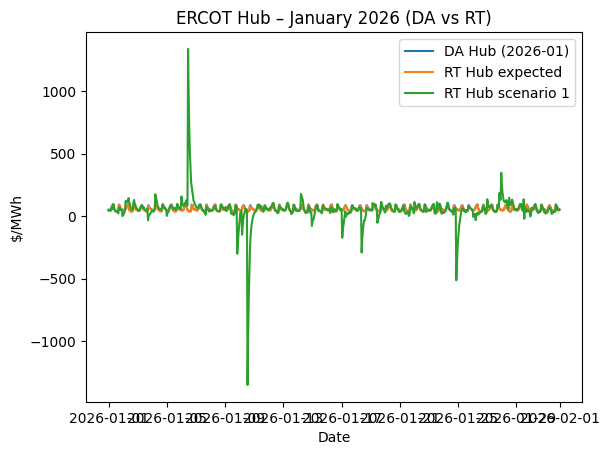

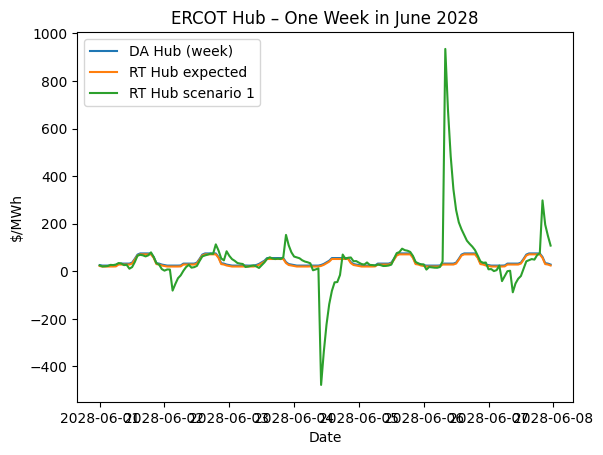

,month_start,forward_used,avg_hourly,fwd_value,diff
0,2026-01-01,OffPeak,59.413495,61.71,-2.296505
1,2026-01-01,Peak,61.640777,66.41,-4.769223
2,2026-02-01,OffPeak,54.159903,59.84,-5.680097
3,2026-02-01,Peak,64.258014,66.38,-2.121986
4,2026-03-01,OffPeak,33.194803,37.77,-4.575197
5,2026-03-01,Peak,44.956135,47.90,-2.943865
6,2026-04-01,OffPeak,29.557422,36.67,-7.112578
7,2026-04-01,Peak,42.972819,47.59,-4.617181


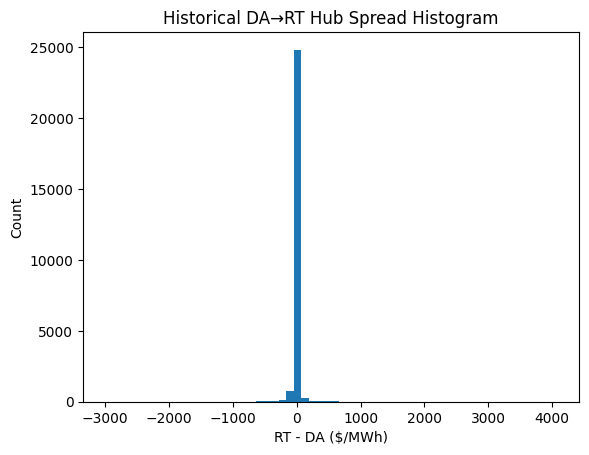

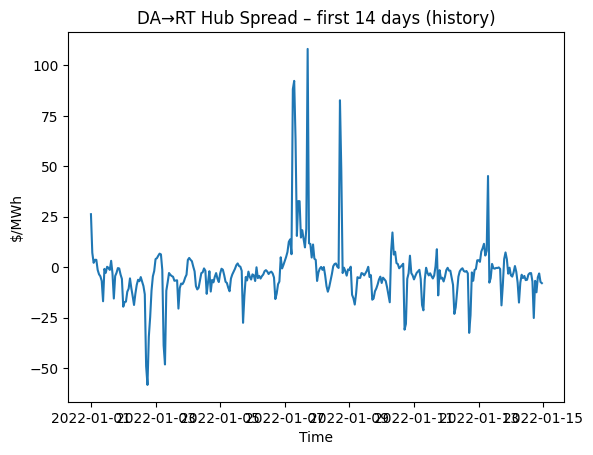

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

cal = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

# 1) First month (2026-01): DA vs RT (expected + one scenario)
m1 = cal[cal["Date"].dt.to_period("M")=="2026-01"].copy()
plt.figure()
plt.plot(m1["Date"], m1["DA_Hub_2026_2030"], label="DA Hub (2026-01)")
plt.plot(m1["Date"], m1["RT_Hub_expected"], label="RT Hub expected")
plt.plot(m1["Date"], m1["RT_Hub_scn1"], label="RT Hub scenario 1")
plt.legend()
plt.title("ERCOT Hub – January 2026 (DA vs RT)")
plt.xlabel("Date")
plt.ylabel("$/MWh")
plt.show()

# 2) A mid-portfolio week (e.g., 2028-06 first week)
wk = cal[(cal["Date"]>=pd.Timestamp("2028-06-01")) & (cal["Date"]<pd.Timestamp("2028-06-08"))]
plt.figure()
plt.plot(wk["Date"], wk["DA_Hub_2026_2030"], label="DA Hub (week)")
plt.plot(wk["Date"], wk["RT_Hub_expected"], label="RT Hub expected")
plt.plot(wk["Date"], wk["RT_Hub_scn1"], label="RT Hub scenario 1")
plt.legend()
plt.title("ERCOT Hub – One Week in June 2028")
plt.xlabel("Date")
plt.ylabel("$/MWh")
plt.show()

# 3) Monthly check: average hourly DA equals forward (should be ≈0 diff after renorm)
cal["month_start"] = cal["Date"].dt.to_period("M").dt.to_timestamp()
cal["forward_used"] = cal["is_peak_5x16"].map({True:"Peak", False:"OffPeak"})
cal["fwd_value"] = cal["Peak"].where(cal["is_peak_5x16"], cal["Off Peak"])

chk = (cal.groupby(["month_start","forward_used"])
          .agg(avg_hourly=("DA_Hub_2026_2030","mean"),
               fwd_value=("fwd_value","first"))
          .reset_index())
chk["diff"] = chk["avg_hourly"] - chk["fwd_value"]
display(chk.head(8))

# 4) Historical DA→RT spread diagnostics (quick)
import numpy as np
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")
sp = (hist[["ts","DA Hub","RT Hub"]].dropna().sort_values("ts").reset_index(drop=True))
sp["spread"] = sp["RT Hub"] - sp["DA Hub"]

plt.figure()
plt.hist(sp["spread"].dropna().values, bins=60)
plt.title("Historical DA→RT Hub Spread Histogram")
plt.xlabel("RT - DA ($/MWh)")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.plot(sp["ts"].iloc[:24*14], sp["spread"].iloc[:24*14])
plt.title("DA→RT Hub Spread – first 14 days (history)")
plt.xlabel("Time")
plt.ylabel("$/MWh")
plt.show()


In [13]:
import pandas as pd
from pathlib import Path

cal = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

cols = ["Date","DA_Hub_2026_2030","RT_Hub_expected","RT_Hub_scn1"]
n = len(cal)
mid = n // 2

print("=== HEAD (first 24 h) ===")
display(cal.loc[:23, cols])

print("\n=== MIDDLE (±24 h around midpoint) ===")
display(cal.loc[mid-24:mid+24, cols])

print("\n=== TAIL (last 24 h) ===")
display(cal.loc[n-24:n-1, cols])


=== HEAD (first 24 h) ===


,Date,DA_Hub_2026_2030,RT_Hub_expected,RT_Hub_scn1
0,2026-01-01 00:00:00,51.048870,47.120928,47.120928
1,2026-01-01 01:00:00,46.813850,42.885908,44.682716
2,2026-01-01 02:00:00,48.002751,44.074809,49.263767
3,2026-01-01 03:00:00,50.994935,47.066994,53.637192
4,2026-01-01 04:00:00,58.446553,54.518611,43.834438
5,2026-01-01 05:00:00,76.186970,72.259029,65.796836
6,2026-01-01 06:00:00,86.394000,82.466058,58.190456
7,2026-01-01 07:00:00,92.974000,89.046058,71.763388
8,2026-01-01 08:00:00,92.974000,89.046058,96.241241
9,2026-01-01 09:00:00,64.589867,60.661925,58.719431



=== MIDDLE (±24 h around midpoint) ===


,Date,DA_Hub_2026_2030,RT_Hub_expected,RT_Hub_scn1
21888,2028-07-01 00:00:00,30.168000,26.240058,47.440240
21889,2028-07-01 01:00:00,30.168000,26.240058,47.609817
21890,2028-07-01 02:00:00,30.168000,26.240058,19.954942
21891,2028-07-01 03:00:00,30.168000,26.240058,27.869412
21892,2028-07-01 04:00:00,30.168000,26.240058,27.630022
21893,2028-07-01 05:00:00,30.168000,26.240058,23.722672
21894,2028-07-01 06:00:00,30.168000,26.240058,28.545134
21895,2028-07-01 07:00:00,30.168000,26.240058,31.759944
21896,2028-07-01 08:00:00,30.168000,26.240058,29.700904
21897,2028-07-01 09:00:00,30.168000,26.240058,22.631422



=== TAIL (last 24 h) ===


,Date,DA_Hub_2026_2030,RT_Hub_expected,RT_Hub_scn1
43800,2030-12-31 00:00:00,30.963248,27.035306,-20.809591
43801,2030-12-31 01:00:00,28.614805,24.686863,-12.874748
43802,2030-12-31 02:00:00,27.910796,23.982855,0.546277
43803,2030-12-31 03:00:00,28.289716,24.361774,-1.561738
43804,2030-12-31 04:00:00,31.352137,27.424195,5.618198
43805,2030-12-31 05:00:00,39.252161,35.324219,19.943786
43806,2030-12-31 06:00:00,56.672000,52.744058,46.096254
43807,2030-12-31 07:00:00,60.970000,57.042058,54.687730
43808,2030-12-31 08:00:00,49.539621,45.611679,39.904648
43809,2030-12-31 09:00:00,37.887248,33.959306,32.784354


In [14]:
import pandas as pd, numpy as np
from pathlib import Path
from dataclasses import dataclass

# Load history & calendar
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
cal  = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

# Build true hourly timestamp and 5x16 flag
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")

@dataclass
class PeakDef:
    start_he: int = 7
    end_he: int   = 22
    weekdays: set = None
    def __post_init__(self):
        if self.weekdays is None:
            self.weekdays = set([0,1,2,3,4])
def is_peak_5x16(ts, peak=PeakDef()):
    return (ts.weekday() in peak.weekdays) and (peak.start_he <= ts.hour <= peak.end_he)

hist["month_num"]    = hist["ts"].dt.month
hist["is_peak_5x16"] = hist["ts"].apply(is_peak_5x16)

# Historical DA→RT hub spread
sp = (hist[["ts","DA Hub","RT Hub","month_num","is_peak_5x16"]]
      .dropna().sort_values("ts").reset_index(drop=True))
sp["spread"] = sp["RT Hub"] - sp["DA Hub"]
sp["lag"]    = sp.groupby(["month_num","is_peak_5x16"])["spread"].shift(1)

# Fit AR(1) by (month × 5×16) bucket
params = []
for (m,pk), g in sp.dropna().groupby(["month_num","is_peak_5x16"]):
    X = np.vstack([np.ones(len(g)), g["lag"].values]).T
    y = g["spread"].values
    a, phi = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - (a + phi * g["lag"].values)

    # Winsorize residuals at 1% and 99% within the bucket
    lo, hi = np.quantile(resid, [0.01, 0.99])
    resid_w = np.clip(resid, lo, hi)

    params.append({
        "month_num": m,
        "is_peak_5x16": pk,
        "a": a, "phi": phi,
        "resid_core": resid_w,             # tempered core
        "resid_tail": resid[(resid>hi) | (resid<lo)]  # rare tail set
    })

param_df = pd.DataFrame(params)
print("AR(1) buckets learned:", len(param_df))

# Helper to simulate with bucketed residuals + optional rare tail mixer
rng = np.random.default_rng(2025)

def simulate_spread_bucketed(cal_df, param_df, tail_prob=0.01):
    out = np.zeros(len(cal_df))
    # start per-bucket at its unconditional mean
    uncond = {}
    for _, row in param_df.iterrows():
        phi = row["phi"]
        a   = row["a"]
        uncond[(row["month_num"], row["is_peak_5x16"])] = (a/(1-phi)) if abs(phi) < 0.999 else 0.0

    prev = None
    for i, r in cal_df.iterrows():
        key = (int(r["month_num"]), bool(r["is_peak_5x16"]))
        rowp = param_df[(param_df["month_num"]==key[0]) & (param_df["is_peak_5x16"]==key[1])]
        if rowp.empty:
            a, phi = 0.0, 0.0
            core = np.array([0.0])
            tail = np.array([])
        else:
            a   = float(rowp["a"].values[0])
            phi = float(rowp["phi"].values[0])
            core = rowp["resid_core"].values[0]
            tail = rowp["resid_tail"].values[0]

        # draw residual: mostly from tempered core; occasionally from tail
        if len(core)==0:
            eps = 0.0
        else:
            if (len(tail)>0) and (rng.random() < tail_prob):
                eps = rng.choice(tail)
            else:
                eps = rng.choice(core)

        # AR(1) update with bucket-specific parameters
        if i == 0:
            prev = uncond.get(key, 0.0)  # initialize at bucket mean
        out[i] = a + phi * prev + eps
        prev = out[i]
    return out

# Prepare calendar keys
cal["month_num"]    = cal["Date"].dt.month
cal["is_peak_5x16"] = cal["is_peak_5x16"].astype(bool)

# Simulate new RT spread scenario & expected RT
spread_scn2 = simulate_spread_bucketed(cal, param_df, tail_prob=0.01)
cal["RT_Hub_scn2"] = cal["DA_Hub_2026_2030"] + spread_scn2

# Expected RT still uses unconditional mean per bucket
uncond_map = { (int(r["month_num"]), bool(r["is_peak_5x16"])): (r["a"]/(1-r["phi"]) if abs(r["phi"])<0.999 else 0.0)
               for _, r in param_df.iterrows() }
cal["RT_Hub_expected2"] = cal.apply(lambda r: cal.loc[0,"DA_Hub_2026_2030"]*0 +
                                    uncond_map.get((int(r["month_num"]), bool(r["is_peak_5x16"])), 0.0), axis=1)
cal["RT_Hub_expected2"] = cal["DA_Hub_2026_2030"] + cal["RT_Hub_expected2"]

# Save
outdir = Path("ercot_step2_outputs")
cal.to_csv(outdir / "ercot_hub_hourly_2026_2030.csv", index=False)
print("Saved:", outdir / "ercot_hub_hourly_2026_2030.csv")


AR(1) buckets learned: 24
Saved: ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv


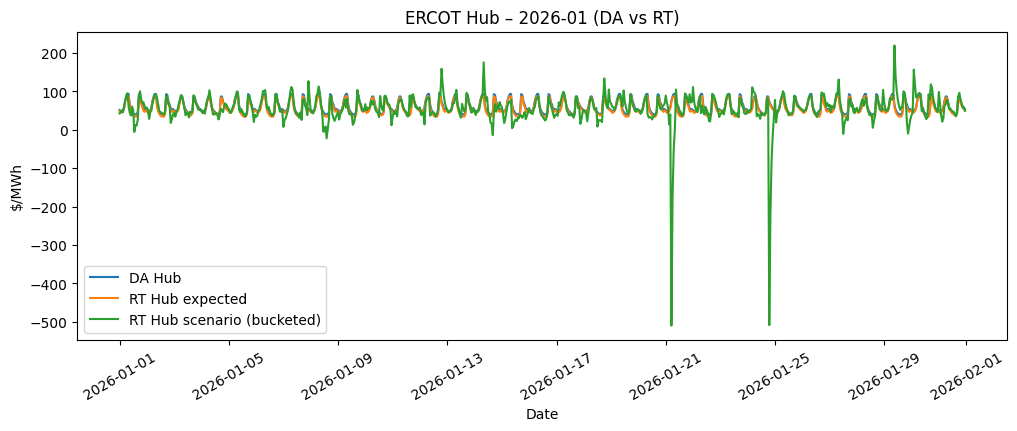

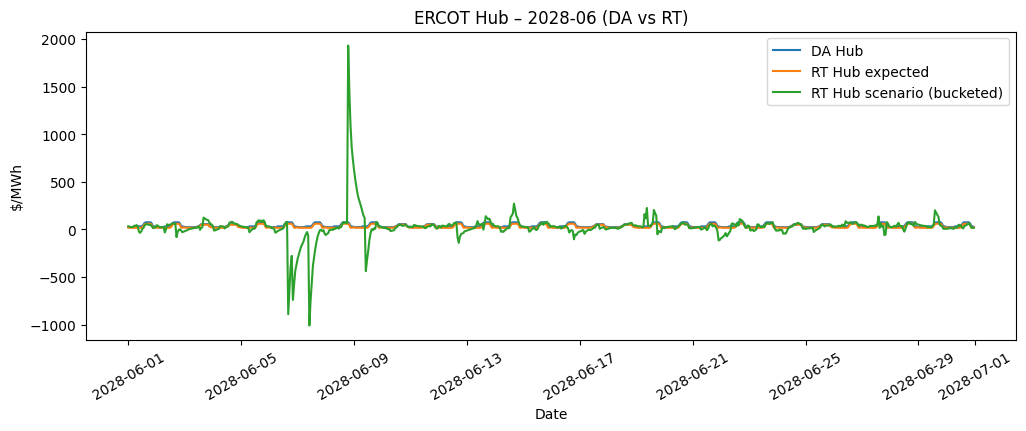

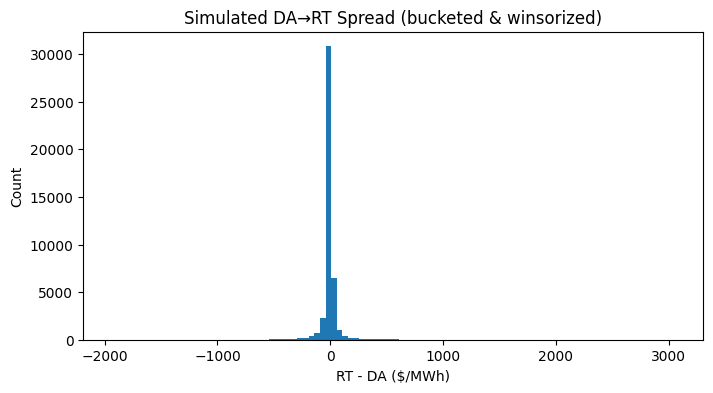

In [15]:
import pandas as pd, matplotlib.pyplot as plt

cal = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

def plot_month(month_str):
    m = cal[cal["Date"].dt.to_period("M")==month_str]
    plt.figure(figsize=(12,4))
    plt.plot(m["Date"], m["DA_Hub_2026_2030"], label="DA Hub")
    plt.plot(m["Date"], m["RT_Hub_expected2"], label="RT Hub expected")
    plt.plot(m["Date"], m["RT_Hub_scn2"], label="RT Hub scenario (bucketed)")
    plt.legend()
    plt.title(f"ERCOT Hub – {month_str} (DA vs RT)")
    plt.xlabel("Date"); plt.ylabel("$/MWh")
    plt.xticks(rotation=30)
    plt.show()

plot_month("2026-01")
plot_month("2028-06")

# Also show distribution of the new simulated spread
cal["spread_scn2"] = cal["RT_Hub_scn2"] - cal["DA_Hub_2026_2030"]
plt.figure(figsize=(8,4))
plt.hist(cal["spread_scn2"], bins=100)
plt.title("Simulated DA→RT Spread (bucketed & winsorized)")
plt.xlabel("RT - DA ($/MWh)"); plt.ylabel("Count")
plt.show()


In [16]:
# === Tempered bucketed AR(1) spreads for pricing runs ===
import pandas as pd, numpy as np
from pathlib import Path
from dataclasses import dataclass

hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
cal  = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

# Build true hourly timestamp + 5x16
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")

@dataclass
class PeakDef:
    start_he: int = 7
    end_he:   int = 22
    weekdays: set = None
    def __post_init__(self):
        if self.weekdays is None:
            self.weekdays = set([0,1,2,3,4])
def is_peak_5x16(ts, peak=PeakDef()):
    return (ts.weekday() in peak.weekdays) and (peak.start_he <= ts.hour <= peak.end_he)

hist["month_num"]    = hist["ts"].dt.month
hist["is_peak_5x16"] = hist["ts"].apply(is_peak_5x16)

# Historical DA->RT hub spread
sp = (hist[["ts","DA Hub","RT Hub","month_num","is_peak_5x16"]]
      .dropna().sort_values("ts").reset_index(drop=True))
sp["spread"] = sp["RT Hub"] - sp["DA Hub"]
sp["lag"]    = sp.groupby(["month_num","is_peak_5x16"])["spread"].shift(1)

# Fit AR(1) per (month, 5x16) and winsorize residuals
params = []
for (m,pk), g in sp.dropna().groupby(["month_num","is_peak_5x16"]):
    X = np.vstack([np.ones(len(g)), g["lag"].values]).T
    y = g["spread"].values
    a, phi = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - (a + phi * g["lag"].values)

    # tighter winsorization for pricing scenarios
    lo, hi = np.quantile(resid, [0.005, 0.995])
    resid_core = np.clip(resid, lo, hi)

    # keep a tiny true tail set
    tail = resid[(resid>hi) | (resid<lo)]

    params.append({
        "month_num": m, "is_peak_5x16": pk,
        "a": a, "phi": phi,
        "resid_core": resid_core,
        "resid_tail": tail
    })

param_df = pd.DataFrame(params)

# Simulate with tiny tail probability and price cap for hub
rng = np.random.default_rng(1234)
TAIL_PROB = 0.002   # 0.2% tail mixer
RT_CAP    = 1000.0  # +/- $/MWh hub cap for pricing runs
RT_FLOOR  = -1000.0

# Precompute unconditional means per bucket
uncond = {}
for _, r in param_df.iterrows():
    phi, a = float(r["phi"]), float(r["a"])
    uncond[(int(r["month_num"]), bool(r["is_peak_5x16"]))] = (a/(1-phi)) if abs(phi) < 0.999 else 0.0

def draw_resid(rowp):
    core = rowp["resid_core"].values[0]
    tail = rowp["resid_tail"].values[0]
    if len(core)==0:
        return 0.0
    if (len(tail)>0) and (rng.random() < TAIL_PROB):
        return rng.choice(tail)
    return rng.choice(core)

# Prepare calendar keys
cal["month_num"]    = cal["Date"].dt.month
cal["is_peak_5x16"] = cal["is_peak_5x16"].astype(bool)

# Generate scenario
spread = np.zeros(len(cal))
prev = None
for i, r in cal.iterrows():
    key = (int(r["month_num"]), bool(r["is_peak_5x16"]))
    rowp = param_df[(param_df["month_num"]==key[0]) & (param_df["is_peak_5x16"]==key[1])]
    if rowp.empty:
        a, phi = 0.0, 0.0
        eps = 0.0
        start = 0.0
    else:
        a, phi = float(rowp["a"].values[0]), float(rowp["phi"].values[0])
        eps = draw_resid(rowp)
        start = uncond.get(key, 0.0)
    if i == 0:
        prev = start
    spread[i] = a + phi * prev + eps
    prev = spread[i]

cal["RT_Hub_scn_pricing"] = np.clip(cal["DA_Hub_2026_2030"] + spread, RT_FLOOR, RT_CAP)

# Expected RT per bucket (DA + bucket mean)
cal["RT_Hub_expected_pricing"] = cal["DA_Hub_2026_2030"] + cal.apply(
    lambda r: uncond.get((int(r["month_num"]), bool(r["is_peak_5x16"])), 0.0), axis=1
)

# Save over existing file
outdir = Path("ercot_step2_outputs")
cal.to_csv(outdir / "ercot_hub_hourly_2026_2030.csv", index=False)
print("Saved:", outdir / "ercot_hub_hourly_2026_2030.csv")


Saved: ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv


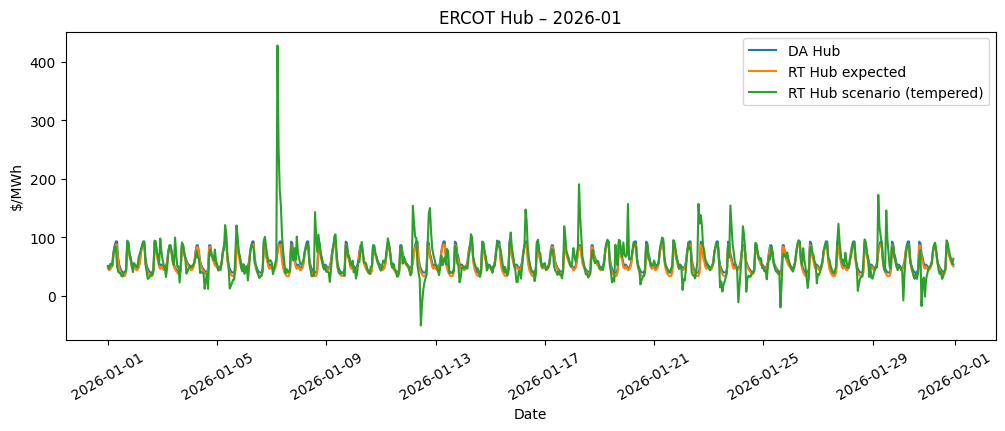

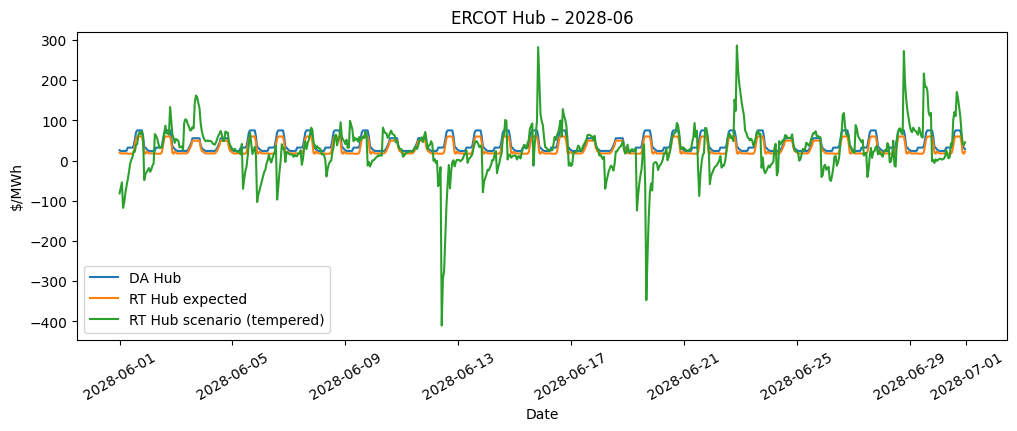

In [17]:
import pandas as pd, matplotlib.pyplot as plt
cal = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

def show_month(m):
    mx = cal[cal["Date"].dt.to_period("M")==m]
    plt.figure(figsize=(12,4))
    plt.plot(mx["Date"], mx["DA_Hub_2026_2030"], label="DA Hub")
    plt.plot(mx["Date"], mx["RT_Hub_expected_pricing"], label="RT Hub expected")
    plt.plot(mx["Date"], mx["RT_Hub_scn_pricing"], label="RT Hub scenario (tempered)")
    plt.legend(); plt.title(f"ERCOT Hub – {m}"); plt.xlabel("Date"); plt.ylabel("$/MWh"); plt.xticks(rotation=30); plt.show()

show_month("2026-01")
show_month("2028-06")


In [18]:
# ===== FIXED: Basis tables + hourly generation (robust, no MultiIndex tricks) =====
import pandas as pd, numpy as np
from pathlib import Path
from dataclasses import dataclass

# Load cleaned history + hub curves
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
cal  = pd.read_csv("ercot_step2_outputs/ercot_hub_hourly_2026_2030.csv", parse_dates=["Date"])

# Build true hourly timestamp and 5x16 flag in history
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")

@dataclass
class PeakDef:
    start_he: int = 7
    end_he:   int = 22
    weekdays: set = None
    def __post_init__(self):
        if self.weekdays is None:
            self.weekdays = set([0,1,2,3,4])

def is_peak_5x16(ts, peak=PeakDef()):
    return (ts.weekday() in peak.weekdays) and (peak.start_he <= ts.hour <= peak.end_he)

# Keys for grouping
hist["month_num"]    = hist["ts"].dt.month
hist["hour"]         = hist["ts"].dt.hour
hist["is_peak_5x16"] = hist["ts"].apply(is_peak_5x16)

# ===== BASIS STATS (busbar - hub) by month_of_year × 5x16 =====
hist["RT_Basis"] = hist["RT Busbar"] - hist["RT Hub"]
hist["DA_Basis"] = hist["DA Busbar"] - hist["DA Hub"]

def q_fn(p):
    return lambda s: s.quantile(p)

basis_tab = (hist.groupby(["month_num","is_peak_5x16"])
    .agg(
        RT_mean=("RT_Basis","mean"), RT_std=("RT_Basis","std"),
        RT_P10=("RT_Basis", q_fn(0.10)), RT_P25=("RT_Basis", q_fn(0.25)),
        RT_P50=("RT_Basis", q_fn(0.50)), RT_P75=("RT_Basis", q_fn(0.75)), RT_P90=("RT_Basis", q_fn(0.90)),
        DA_mean=("DA_Basis","mean"), DA_std=("DA_Basis","std"),
        DA_P10=("DA_Basis", q_fn(0.10)), DA_P25=("DA_Basis", q_fn(0.25)),
        DA_P50=("DA_Basis", q_fn(0.50)), DA_P75=("DA_Basis", q_fn(0.75)), DA_P90=("DA_Basis", q_fn(0.90)),
    )
    .reset_index()
)

# Winsorized basis pools for sampling (pricing-stable)
def winsor(x, lo=0.01, hi=0.99):
    if len(x)==0: return x
    a,b = np.quantile(x, [lo, hi])
    return np.clip(x, a, b)

hist_key = hist.assign(key=list(zip(hist["month_num"], hist["is_peak_5x16"])))
basis_pool_RT = {k: winsor(g["RT_Basis"].dropna().values, 0.01, 0.99) for k,g in hist_key.groupby("key")}
basis_pool_DA = {k: winsor(g["DA_Basis"].dropna().values, 0.01, 0.99) for k,g in hist_key.groupby("key")}

# ===== HOURLY GENERATION (2026–2030) =====
# Expected MW by month-of-year × 5×16 (average over history)
gen_rate = (hist.groupby(["month_num","is_peak_5x16"])["Gen"]
            .mean().rename("gen_MW").reset_index())

# Historical gen shape by hour-of-day within (month_of_year × 5×16)
gen_shape = (hist.groupby(["month_num","is_peak_5x16","hour"])["Gen"]
             .mean().rename("shape_mu").reset_index())

# Future calendar keys
cal["month_num"]    = cal["Date"].dt.month
cal["hour"]         = cal["Date"].dt.hour
cal["is_peak_5x16"] = cal["is_peak_5x16"].astype(bool)
cal["month_start"]  = cal["Date"].dt.to_period("M").dt.to_timestamp()

# Count hours per month × 5×16 in the future period
counts = (cal.groupby(["month_start","is_peak_5x16"]).size()
          .rename("n_hours").reset_index())
cal = cal.merge(counts, on=["month_start","is_peak_5x16"], how="left")

# Join expected MW rate for that month-of-year × 5×16
cal = cal.merge(gen_rate, on=["month_num","is_peak_5x16"], how="left")
cal["gen_MW"] = cal["gen_MW"].fillna(0.0)

# Monthly target MWh for that month × 5×16 = mean MW × number of hours
cal["target_MWh"] = cal["gen_MW"] * cal["n_hours"]

# Join hour-of-day shape and normalize within each (month_start × 5×16)
cal = cal.merge(gen_shape, on=["month_num","is_peak_5x16","hour"], how="left")
cal["shape_mu"] = cal["shape_mu"].clip(lower=0).fillna(0.0)

norm = (cal.groupby(["month_start","is_peak_5x16"])["shape_mu"].sum()
          .rename("shape_sum").reset_index())
cal = cal.merge(norm, on=["month_start","is_peak_5x16"], how="left")
cal["shape_sum"] = cal["shape_sum"].replace({0: np.nan})
cal["w_norm"] = (cal["shape_mu"] / cal["shape_sum"]).fillna(0.0)

# Allocate hourly MWh
cal["Gen_MWh"] = cal["w_norm"] * cal["target_MWh"]

# Save intermediates
outdir = Path("ercot_step3_outputs"); outdir.mkdir(exist_ok=True, parents=True)
basis_tab.to_csv(outdir / "ercot_basis_tail_table.csv", index=False)
cal.to_csv(outdir / "ercot_prices_gen_hourly_2026_2030.csv", index=False)

print("Saved:", outdir / "ercot_basis_tail_table.csv", "and", outdir / "ercot_prices_gen_hourly_2026_2030.csv")


Saved: ercot_step3_outputs/ercot_basis_tail_table.csv and ercot_step3_outputs/ercot_prices_gen_hourly_2026_2030.csv


In [19]:
import pandas as pd

cal = pd.read_csv("ercot_step3_outputs/ercot_prices_gen_hourly_2026_2030.csv", parse_dates=["Date"])
basis_tab = pd.read_csv("ercot_step3_outputs/ercot_basis_tail_table.csv")

cols = ["Date","is_peak_5x16","hour","DA_Hub_2026_2030","RT_Hub_expected_pricing",
        "Gen_MWh","month_num","month_start","target_MWh","w_norm"]

n = len(cal)
mid = n // 2

print("=== HEAD (first 24 h) ===")
display(cal.loc[:23, cols])

print("\n=== MIDDLE (±24 h around midpoint) ===")
display(cal.loc[mid-24:mid+24, cols])

print("\n=== TAIL (last 24 h) ===")
display(cal.loc[n-24:n-1, cols])

print("\n=== BASIS TABLE (first 10 rows) ===")
display(basis_tab.head(10))


=== HEAD (first 24 h) ===


,Date,is_peak_5x16,hour,DA_Hub_2026_2030,RT_Hub_expected_pricing,Gen_MWh,month_num,month_start,target_MWh,w_norm
0,2026-01-01 00:00:00,False,0,51.048870,47.942326,15.811828,1,2026-01-01,7278.833333,0.002172
1,2026-01-01 01:00:00,False,1,46.813850,43.707307,15.177419,1,2026-01-01,7278.833333,0.002085
2,2026-01-01 02:00:00,False,2,48.002751,44.896207,16.117204,1,2026-01-01,7278.833333,0.002214
3,2026-01-01 03:00:00,False,3,50.994935,47.888392,16.970968,1,2026-01-01,7278.833333,0.002332
4,2026-01-01 04:00:00,False,4,58.446553,55.340010,17.543011,1,2026-01-01,7278.833333,0.002410
5,2026-01-01 05:00:00,False,5,76.186970,73.080427,18.303226,1,2026-01-01,7278.833333,0.002515
6,2026-01-01 06:00:00,False,6,86.394000,83.287456,18.613978,1,2026-01-01,7278.833333,0.002557
7,2026-01-01 07:00:00,True,7,92.974000,87.204450,19.286364,1,2026-01-01,6684.733333,0.002885
8,2026-01-01 08:00:00,True,8,92.974000,87.204450,18.078788,1,2026-01-01,6684.733333,0.002704
9,2026-01-01 09:00:00,True,9,64.589867,58.820317,16.103030,1,2026-01-01,6684.733333,0.002409



=== MIDDLE (±24 h around midpoint) ===


,Date,is_peak_5x16,hour,DA_Hub_2026_2030,RT_Hub_expected_pricing,Gen_MWh,month_num,month_start,target_MWh,w_norm
21888,2028-07-01 00:00:00,False,0,30.168000,30.859897,29.668514,7,2028-07-01,10489.536242,0.002828
21889,2028-07-01 01:00:00,False,1,30.168000,30.859897,26.397061,7,2028-07-01,10489.536242,0.002517
21890,2028-07-01 02:00:00,False,2,30.168000,30.859897,22.222806,7,2028-07-01,10489.536242,0.002119
21891,2028-07-01 03:00:00,False,3,30.168000,30.859897,18.866949,7,2028-07-01,10489.536242,0.001799
21892,2028-07-01 04:00:00,False,4,30.168000,30.859897,16.161749,7,2028-07-01,10489.536242,0.001541
21893,2028-07-01 05:00:00,False,5,30.168000,30.859897,14.661710,7,2028-07-01,10489.536242,0.001398
21894,2028-07-01 06:00:00,False,6,30.168000,30.859897,12.293058,7,2028-07-01,10489.536242,0.001172
21895,2028-07-01 07:00:00,False,7,30.168000,30.859897,7.881503,7,2028-07-01,10489.536242,0.000751
21896,2028-07-01 08:00:00,False,8,30.168000,30.859897,9.978742,7,2028-07-01,10489.536242,0.000951
21897,2028-07-01 09:00:00,False,9,30.168000,30.859897,14.219352,7,2028-07-01,10489.536242,0.001356



=== TAIL (last 24 h) ===


,Date,is_peak_5x16,hour,DA_Hub_2026_2030,RT_Hub_expected_pricing,Gen_MWh,month_num,month_start,target_MWh,w_norm
43800,2030-12-31 00:00:00,False,0,30.963248,21.458184,14.538637,12,2030-12-01,5762.169799,0.002523
43801,2030-12-31 01:00:00,False,1,28.614805,19.109741,13.784654,12,2030-12-01,5762.169799,0.002392
43802,2030-12-31 02:00:00,False,2,27.910796,18.405733,12.514392,12,2030-12-01,5762.169799,0.002172
43803,2030-12-31 03:00:00,False,3,28.289716,18.784653,13.699683,12,2030-12-01,5762.169799,0.002378
43804,2030-12-31 04:00:00,False,4,31.352137,21.847073,15.080730,12,2030-12-01,5762.169799,0.002617
43805,2030-12-31 05:00:00,False,5,39.252161,29.747098,14.919393,12,2030-12-01,5762.169799,0.002589
43806,2030-12-31 06:00:00,False,6,56.672000,47.166936,15.714247,12,2030-12-01,5762.169799,0.002727
43807,2030-12-31 07:00:00,True,7,60.970000,62.905263,16.781538,12,2030-12-01,6167.107692,0.002721
43808,2030-12-31 08:00:00,True,8,49.539621,51.474884,15.486154,12,2030-12-01,6167.107692,0.002511
43809,2030-12-31 09:00:00,True,9,37.887248,39.822511,14.890769,12,2030-12-01,6167.107692,0.002415



=== BASIS TABLE (first 10 rows) ===


,month_num,is_peak_5x16,RT_mean,RT_std,RT_P10,RT_P25,RT_P50,RT_P75,RT_P90,DA_mean,DA_std,DA_P10,DA_P25,DA_P50,DA_P75,DA_P90
0,1,False,-6.348532,22.169744,-24.0190,-9.08825,0.000,0.14050,1.3780,-8.708699,34.252265,-21.150,-11.6925,-0.940,0.1000,0.600
1,1,True,-5.738290,17.117861,-24.6625,-4.55000,0.000,0.10725,1.3430,-9.297301,39.847534,-24.845,-11.8125,-0.225,0.2700,0.965
2,2,False,-3.724347,23.813405,-17.8309,-4.79900,0.000,0.37150,1.7665,-5.176936,9.943035,-15.752,-8.3325,-0.695,0.1100,0.704
3,2,True,-6.513800,31.682286,-23.5520,-13.90875,-0.200,0.09225,1.6895,-10.097326,14.943544,-28.040,-18.1025,-3.925,0.0200,0.925
4,3,False,-6.483061,27.828648,-24.6560,-11.87200,-0.150,0.49000,1.9552,-6.477381,9.728603,-21.932,-11.7100,-1.250,0.2500,1.114
5,3,True,-8.795176,25.944933,-31.7287,-17.44350,-0.191,0.16775,1.3664,-9.931670,12.962343,-29.646,-20.0025,-2.825,0.0725,0.920
6,4,False,-10.968564,36.761724,-33.5272,-15.56500,-0.274,0.17275,2.0711,-9.627500,15.175337,-30.000,-16.2950,-1.760,0.2025,1.280
7,4,True,-14.138791,30.995159,-46.4740,-22.58075,-2.480,0.06550,2.5458,-13.829653,18.618463,-40.045,-24.8650,-5.455,0.0600,1.273
8,5,False,-9.380323,20.338818,-41.7020,-9.18300,0.000,0.04425,0.9226,-9.222080,21.151505,-30.260,-10.1050,-0.175,0.1800,1.250
9,5,True,-19.887116,142.594815,-68.8320,-30.21300,-0.230,0.02700,1.9350,-18.574926,32.537516,-60.130,-30.0100,-4.035,0.0500,2.320


In [20]:
import numpy as np
import pandas as pd

cal = pd.read_csv("ercot_step3_outputs/ercot_prices_gen_hourly_2026_2030.csv", parse_dates=["Date"])

# 1) For each month × period, weights should sum ~1 and allocated Gen_MWh should sum to target_MWh
chk = (cal.groupby(["month_start","is_peak_5x16"])
         .agg(W=("w_norm","sum"),
              MWh_alloc=("Gen_MWh","sum"),
              MWh_target=("target_MWh","first"))
         .reset_index())
chk["w_diff"]   = chk["W"] - 1.0
chk["mwh_diff"] = chk["MWh_alloc"] - chk["MWh_target"]

print("Weights sum to 1? (abs max):", chk["w_diff"].abs().max())
print("Allocated vs target MWh (abs max diff):", chk["mwh_diff"].abs().max())

display(chk.head(8))


Weights sum to 1? (abs max): 2.4646951146678475e-14
Allocated vs target MWh (abs max diff): 1.8189894035458565e-12


,month_start,is_peak_5x16,W,MWh_alloc,MWh_target,w_diff,mwh_diff
0,2026-01-01,False,1.0,7278.833333,7278.833333,-2.464695e-14,0.0
1,2026-01-01,True,1.0,6684.733333,6684.733333,-1.665335e-14,0.0
2,2026-02-01,False,1.0,5459.837594,5459.837594,-1.687539e-14,0.0
3,2026-02-01,True,1.0,6086.098361,6086.098361,-1.598721e-14,0.0
4,2026-03-01,False,1.0,8036.372688,8036.372688,-1.876277e-14,0.0
5,2026-03-01,True,1.0,8060.176119,8060.176119,-1.665335e-14,0.0
6,2026-04-01,False,1.0,6306.025000,6306.025000,-2.120526e-14,0.0
7,2026-04-01,True,1.0,8116.498413,8116.498413,-1.654232e-14,0.0


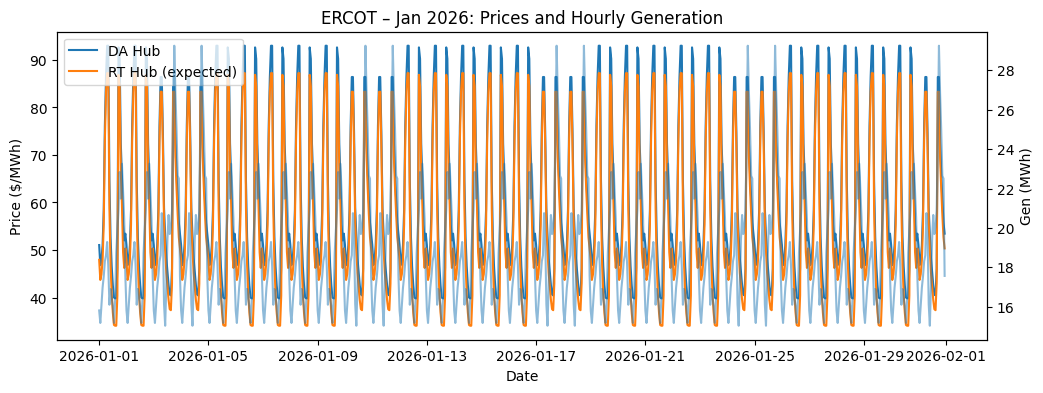

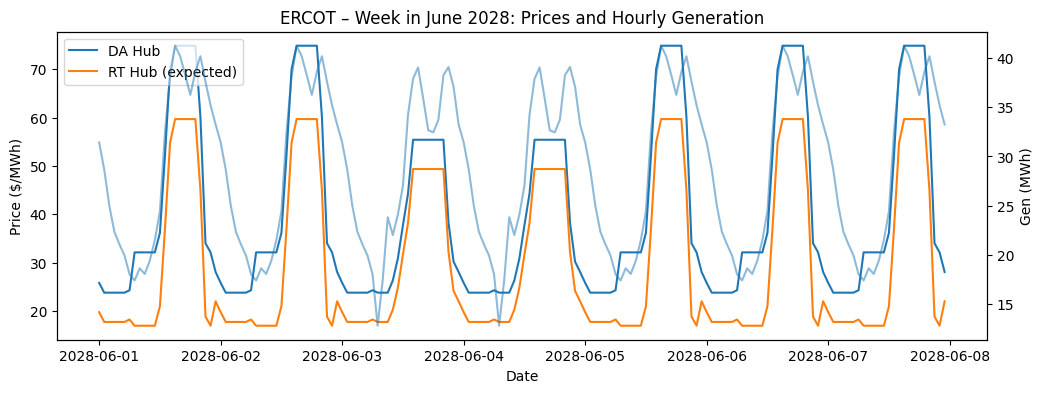

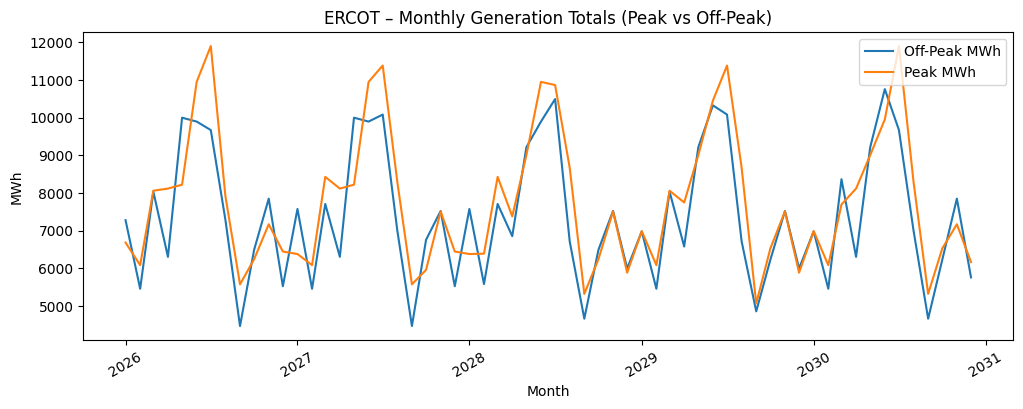

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

cal = pd.read_csv("ercot_step3_outputs/ercot_prices_gen_hourly_2026_2030.csv", parse_dates=["Date"])

# ---- 1) January 2026: hourly DA hub + expected RT + hourly Gen_MWh (secondary axis) ----
m = cal[cal["Date"].dt.to_period("M") == "2026-01"].copy()

plt.figure(figsize=(12,4))
plt.plot(m["Date"], m["DA_Hub_2026_2030"], label="DA Hub")
plt.plot(m["Date"], m["RT_Hub_expected_pricing"], label="RT Hub (expected)")
plt.legend(loc="upper left")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Date")
ax2 = plt.twinx()
ax2.plot(m["Date"], m["Gen_MWh"], label="Gen MWh", alpha=0.5)
ax2.set_ylabel("Gen (MWh)")
plt.title("ERCOT – Jan 2026: Prices and Hourly Generation")
plt.xticks(rotation=30)
plt.show()

# ---- 2) One week in June 2028: prices + gen ----
wk = cal[(cal["Date"]>=pd.Timestamp("2028-06-01")) & (cal["Date"]<pd.Timestamp("2028-06-08"))]
plt.figure(figsize=(12,4))
plt.plot(wk["Date"], wk["DA_Hub_2026_2030"], label="DA Hub")
plt.plot(wk["Date"], wk["RT_Hub_expected_pricing"], label="RT Hub (expected)")
plt.legend(loc="upper left")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Date")
ax2 = plt.twinx()
ax2.plot(wk["Date"], wk["Gen_MWh"], label="Gen MWh", alpha=0.5)
ax2.set_ylabel("Gen (MWh)")
plt.title("ERCOT – Week in June 2028: Prices and Hourly Generation")
plt.xticks(rotation=30)
plt.show()

# ---- 3) Monthly generation totals: Peak vs Off-peak bars (should look seasonally sensible) ----
cal["Month"] = cal["Date"].dt.to_period("M").dt.to_timestamp()
gmon = (cal.groupby(["Month","is_peak_5x16"])["Gen_MWh"].sum().reset_index())
gmon_pivot = gmon.pivot(index="Month", columns="is_peak_5x16", values="Gen_MWh").fillna(0.0)
gmon_pivot.columns = ["Off-Peak MWh", "Peak MWh"]

plt.figure(figsize=(12,4))
plt.plot(gmon_pivot.index, gmon_pivot["Off-Peak MWh"], label="Off-Peak MWh")
plt.plot(gmon_pivot.index, gmon_pivot["Peak MWh"], label="Peak MWh")
plt.legend()
plt.title("ERCOT – Monthly Generation Totals (Peak vs Off-Peak)")
plt.xlabel("Month"); plt.ylabel("MWh")
plt.xticks(rotation=30)
plt.show()


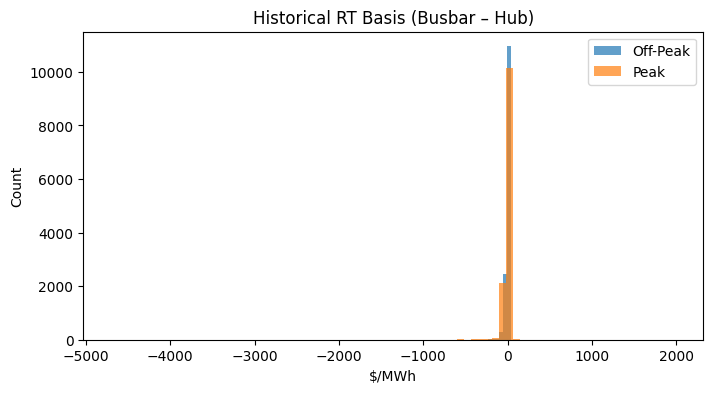

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Rebuild historical basis quickly for a histogram by period
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv", parse_dates=["Date"])
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")
hist["is_peak_5x16"] = hist["ts"].apply(lambda ts: (ts.weekday() in {0,1,2,3,4}) and (7 <= ts.hour <= 22))
hist["RT_Basis"] = hist["RT Busbar"] - hist["RT Hub"]

plt.figure(figsize=(8,4))
plt.hist(hist.loc[~hist["is_peak_5x16"], "RT_Basis"].dropna(), bins=80, alpha=0.7, label="Off-Peak")
plt.hist(hist.loc[ hist["is_peak_5x16"], "RT_Basis"].dropna(), bins=80, alpha=0.7, label="Peak")
plt.legend(); plt.title("Historical RT Basis (Busbar – Hub)")
plt.xlabel("$/MWh"); plt.ylabel("Count")
plt.show()


In [23]:
#This is supporting that infinite code. Check if its required
# --- ERCOT valuation helpers: constants, loading, basis pools, RT spread model, utilities ---

import numpy as np, pandas as pd
from pathlib import Path
from dataclasses import dataclass

# ---- constants (safe defaults) ----
DISCOUNT_RATE = 0.0          # energy-only $/MWh; keep 0 per prompt
N_SCENARIOS   = 100
TAIL_PROB     = 0.002        # small probability of tail residuals
RT_CAP_BOUNDS = (-1000.0, 1000.0)  # tame pricing runs
WINSOR_BOUNDS = (0.01, 0.99)

# ---- load inputs written by your earlier steps ----
cal  = pd.read_csv("ercot_step3_outputs/ercot_prices_gen_hourly_2026_2030.csv", parse_dates=["Date"])
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv",               parse_dates=["Date"])

# calendar arrays for fast vector ops
DA_hub   = cal["DA_Hub_2026_2030"].values
gen_mwh  = cal["Gen_MWh"].fillna(0).values
month_no = cal["Date"].dt.month.astype(int).values
is_peak  = cal["is_peak_5x16"].astype(bool).values
n_hours  = len(cal)

# ---- build basis pools (winsorized) ----
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")
hist["month_num"]    = hist["ts"].dt.month
hist["is_peak_5x16"] = hist["ts"].apply(lambda t: (t.weekday() in {0,1,2,3,4}) and (7 <= t.hour <= 22))
hist["RT_Basis"] = hist["RT Busbar"] - hist["RT Hub"]
hist["DA_Basis"] = hist["DA Busbar"] - hist["DA Hub"]

def winsor(x, lo=WINSOR_BOUNDS[0], hi=WINSOR_BOUNDS[1]):
    if len(x)==0: return x
    a,b = np.quantile(x, [lo, hi])
    return np.clip(x, a, b)

hist_key = hist.assign(key=list(zip(hist["month_num"], hist["is_peak_5x16"])))
basis_pool_RT = {k: winsor(g["RT_Basis"].dropna().values) for k,g in hist_key.groupby("key")}
basis_pool_DA = {k: winsor(g["DA_Basis"].dropna().values) for k,g in hist_key.groupby("key")}

# ---- bucketed AR(1) for DA→RT hub spread, tempered tails ----
sp = (hist[["ts","DA Hub","RT Hub","month_num","is_peak_5x16"]]
      .dropna().sort_values("ts").reset_index(drop=True))
sp["spread"] = sp["RT Hub"] - sp["DA Hub"]
sp["lag"]    = sp.groupby(["month_num","is_peak_5x16"])["spread"].shift(1)

params = []
for (m,pk), g in sp.dropna().groupby(["month_num","is_peak_5x16"]):
    X = np.vstack([np.ones(len(g)), g["lag"].values]).T
    y = g["spread"].values
    a, phi = np.linalg.lstsq(X, y, rcond=None)[0]
    resid  = y - (a + phi*g["lag"].values)
    params.append({
        "month_num": int(m), "is_peak_5x16": bool(pk),
        "a": float(a), "phi": float(phi),
        "resid_core": winsor(resid),
        "resid_tail": resid[(resid < np.quantile(resid, WINSOR_BOUNDS[0])) |
                            (resid > np.quantile(resid, WINSOR_BOUNDS[1]))]
    })
param_df = pd.DataFrame(params)
uncond_map = {(int(r["month_num"]), bool(r["is_peak_5x16"])): (r["a"]/(1-r["phi"]) if abs(r["phi"])<0.999 else 0.0)
              for _, r in param_df.iterrows()}

rng = np.random.default_rng(2026)

def simulate_rt_spread_bucketed(month_no_arr, peak_arr, tail_prob=TAIL_PROB):
    out = np.zeros(len(month_no_arr)); prev = None
    for i,(m,pk) in enumerate(zip(month_no_arr, peak_arr)):
        row = param_df[(param_df["month_num"]==m) & (param_df["is_peak_5x16"]==pk)]
        if row.empty:
            a, phi, eps, start = 0.0, 0.0, 0.0, 0.0
        else:
            a, phi = float(row["a"].values[0]), float(row["phi"].values[0])
            core, tail = row["resid_core"].values[0], row["resid_tail"].values[0]
            eps = 0.0 if len(core)==0 else (rng.choice(tail) if (len(tail)>0 and rng.random()<tail_prob) else rng.choice(core))
            start = uncond_map.get((m, pk), 0.0)
        if i==0: prev = start
        out[i] = a + phi*prev + eps
        prev   = out[i]
    return out

def sample_basis_paths(pool):
    arr = np.zeros(n_hours)
    for i,(m,pk) in enumerate(zip(month_no, is_peak)):
        draw = pool.get((m, pk))
        arr[i] = 0.0 if (draw is None or len(draw)==0) else rng.choice(draw)
    return arr

# ---- revenue utilities ----
def discounted_sum(x, r=DISCOUNT_RATE):
    if r==0: return float(np.sum(x))
    disc = (1.0/(1.0+r)) ** (np.arange(len(x))/8760.0)
    return float(np.sum(x*disc))

def revenue_and_unit_value(price, gen, neg_policy="take", r=DISCOUNT_RATE):
    gen_eff = np.where(price < 0, 0.0, gen) if neg_policy=="notake" else gen
    rev = discounted_sum(price*gen_eff, r=r)
    mwh = discounted_sum(gen_eff, r=r)
    return rev, (np.nan if mwh<=0 else rev/mwh)

def run_scenarios_with_policy(neg_policy, N=N_SCENARIOS, discount_rate=DISCOUNT_RATE):
    rows=[]
    for _ in range(N):
        spread   = simulate_rt_spread_bucketed(month_no, is_peak, tail_prob=TAIL_PROB)
        RT_hub_s = np.clip(DA_hub + spread, RT_CAP_BOUNDS[0], RT_CAP_BOUNDS[1])
        DA_basis = sample_basis_paths(basis_pool_DA)
        RT_basis = sample_basis_paths(basis_pool_RT)

        prices = {
            "DA_Hub": DA_hub,
            "RT_Hub": RT_hub_s,
            "DA_Bus": DA_hub + DA_basis,
            "RT_Bus": RT_hub_s + RT_basis,
        }
        out={}
        for name, P in prices.items():
            rev, uv = revenue_and_unit_value(P, gen_mwh, neg_policy=neg_policy, r=discount_rate)
            out[f"{name}_rev"] = rev; out[f"{name}_uv"] = uv
        rows.append(out)
    return pd.DataFrame(rows)

def summarize_uv(series):
    return pd.Series({"Mean": series.mean(),
                      "P50":  series.quantile(0.50),
                      "P75":  series.quantile(0.75),
                      "P90":  series.quantile(0.90)})
print("Helpers ready.")


Helpers ready.


In [24]:
#Again same but with upgraded method to reduce time
import numpy as np, pandas as pd
from pathlib import Path

# ---------------- CONFIG ----------------
DISCOUNT_RATE = 0.0          # per hackathon prompt, energy value only
N_SCENARIOS   = 300          # you can try 300; should run fast (~seconds). Bump later if you want.
TAIL_PROB     = 0.002        # rare tail shock injection for RT spread
RT_CAP_BOUNDS = (-1000.0, 1000.0)
WINSOR_BOUNDS = (0.01, 0.99)

# ---------------- LOAD INPUTS ----------------
cal  = pd.read_csv("ercot_step3_outputs/ercot_prices_gen_hourly_2026_2030.csv", parse_dates=["Date"])
hist = pd.read_csv("ercot_step1_outputs/ercot_history_tidy.csv",               parse_dates=["Date"])

# Calendar-derived arrays
DA_hub   = cal["DA_Hub_2026_2030"].values           # deterministic DA hub price path 2026-2030
gen_mwh  = cal["Gen_MWh"].fillna(0).values          # hourly generation allocation (MWh)
month_no = cal["Date"].dt.month.astype(int).values  # 1..12 per hour
is_peak  = cal["is_peak_5x16"].astype(bool).values  # True if 5x16, False otherwise
n_hours  = len(cal)

# ---------------- BUILD BASIS POOLS ----------------
hist["HE"] = pd.to_numeric(hist["HE"], errors="coerce").astype("Int64")
hist["ts"] = hist["Date"].dt.normalize() + pd.to_timedelta(hist["HE"] - 1, unit="h")
hist["month_num"]    = hist["ts"].dt.month
hist["is_peak_5x16"] = hist["ts"].apply(lambda t: (t.weekday() in {0,1,2,3,4}) and (7 <= t.hour <= 22))

# DA/RT basis = busbar minus hub
hist["RT_Basis"] = hist["RT Busbar"] - hist["RT Hub"]
hist["DA_Basis"] = hist["DA Busbar"] - hist["DA Hub"]

def winsor(x, lo=WINSOR_BOUNDS[0], hi=WINSOR_BOUNDS[1]):
    if len(x) == 0:
        return x
    a,b = np.quantile(x, [lo, hi])
    return np.clip(x, a, b)

# Build pools by (month_num, is_peak_5x16)
hist_key = hist.assign(key=list(zip(hist["month_num"], hist["is_peak_5x16"])))
basis_pool_RT = {k: winsor(g["RT_Basis"].dropna().values) for k,g in hist_key.groupby("key")}
basis_pool_DA = {k: winsor(g["DA_Basis"].dropna().values) for k,g in hist_key.groupby("key")}

# For speed: pre-resolve the correct pool for each hour so we don't dict lookup inside the loop repeatedly
hour_pool_DA = []
hour_pool_RT = []
for m, pk in zip(month_no, is_peak):
    hour_pool_DA.append(basis_pool_DA.get((m, bool(pk)), np.array([0.0])))
    hour_pool_RT.append(basis_pool_RT.get((m, bool(pk)), np.array([0.0])))

# ---------------- FIT BUCKETED AR(1) FOR RT SPREAD ----------------
# spread_t = a + phi * spread_{t-1} + residual_t
sp = (hist[["ts","DA Hub","RT Hub","month_num","is_peak_5x16"]]
      .dropna()
      .sort_values("ts")
      .reset_index(drop=True))
sp["spread"] = sp["RT Hub"] - sp["DA Hub"]
sp["lag"]    = sp.groupby(["month_num","is_peak_5x16"])["spread"].shift(1)

param_rows = []
for (m, pk), g in sp.dropna().groupby(["month_num","is_peak_5x16"]):
    X = np.vstack([np.ones(len(g)), g["lag"].values]).T
    y = g["spread"].values
    a, phi = np.linalg.lstsq(X, y, rcond=None)[0]
    resid  = y - (a + phi * g["lag"].values)

    # clip residual core to avoid insane tails dominating valuation
    lo, hi = np.quantile(resid, [WINSOR_BOUNDS[0], WINSOR_BOUNDS[1]])
    resid_core = np.clip(resid, lo, hi)
    resid_tail = resid[(resid < lo) | (resid > hi)]

    if abs(phi) < 0.999:
        uncond_mean = a / (1 - phi)
    else:
        uncond_mean = 0.0

    param_rows.append({
        "key":        (int(m), bool(pk)),
        "a":          float(a),
        "phi":        float(phi),
        "uncond":     float(uncond_mean),
        "core":       resid_core if len(resid_core)>0 else np.array([0.0]),
        "tail":       resid_tail if len(resid_tail)>0 else np.array([0.0]),
    })

param_dict = {row["key"]: row for row in param_rows}

# For speed: precompute per-hour AR(1) parameters and residual pools
hour_a      = np.zeros(n_hours)
hour_phi    = np.zeros(n_hours)
hour_uncond = np.zeros(n_hours)
hour_core   = [None]*n_hours
hour_tail   = [None]*n_hours

for i,(m,pk) in enumerate(zip(month_no, is_peak)):
    info = param_dict.get((int(m), bool(pk)))
    if info is None:
        hour_a[i]      = 0.0
        hour_phi[i]    = 0.0
        hour_uncond[i] = 0.0
        hour_core[i]   = np.array([0.0])
        hour_tail[i]   = np.array([0.0])
    else:
        hour_a[i]      = info["a"]
        hour_phi[i]    = info["phi"]
        hour_uncond[i] = info["uncond"]
        hour_core[i]   = info["core"]
        hour_tail[i]   = info["tail"]

rng = np.random.default_rng(2028)

# ---------------- STREAMING SIMULATION (VECTORIZED ACROSS SCENARIOS) ----------------
# We'll evolve N_SCENARIOS spreads in parallel as vectors, hour by hour.
# We'll simultaneously accumulate revenues for:
#   - 4 products (DA Hub, RT Hub, DA Busbar, RT Busbar)
#   - under 2 policies (take, notake)
#
# So we maintain running revenue and MWh for each product/policy as arrays of length N_SCENARIOS.

# initialize spread state for each scenario at hour 0 using that hour's bucket mean
spread_state = np.full(N_SCENARIOS, hour_uncond[0], dtype=float)

# revenue accumulators for each product/policy
rev_take_DAHub    = np.zeros(N_SCENARIOS)
rev_take_RTHub    = np.zeros(N_SCENARIOS)
rev_take_DABus    = np.zeros(N_SCENARIOS)
rev_take_RTBus    = np.zeros(N_SCENARIOS)

mwh_take_DAHub    = np.zeros(N_SCENARIOS)
mwh_take_RTHub    = np.zeros(N_SCENARIOS)
mwh_take_DABus    = np.zeros(N_SCENARIOS)
mwh_take_RTBus    = np.zeros(N_SCENARIOS)

rev_notake_DAHub  = np.zeros(N_SCENARIOS)
rev_notake_RTHub  = np.zeros(N_SCENARIOS)
rev_notake_DABus  = np.zeros(N_SCENARIOS)
rev_notake_RTBus  = np.zeros(N_SCENARIOS)

mwh_notake_DAHub  = np.zeros(N_SCENARIOS)
mwh_notake_RTHub  = np.zeros(N_SCENARIOS)
mwh_notake_DABus  = np.zeros(N_SCENARIOS)
mwh_notake_RTBus  = np.zeros(N_SCENARIOS)

for i in range(n_hours):
    # -- 1. advance RT spread for this hour across all scenarios --
    a_i   = hour_a[i]
    phi_i = hour_phi[i]

    core_pool = hour_core[i]
    tail_pool = hour_tail[i]

    # draw residuals for all scenarios at this hour
    # start with core samples
    if len(core_pool) == 0:
        eps_all = np.zeros(N_SCENARIOS)
    else:
        eps_all = rng.choice(core_pool, size=N_SCENARIOS)

    # occasionally replace some with tail values
    if len(tail_pool) > 1 and TAIL_PROB > 0.0:
        tail_mask = rng.random(N_SCENARIOS) < TAIL_PROB
        if tail_mask.any():
            eps_all[tail_mask] = rng.choice(tail_pool, size=tail_mask.sum())

    # AR(1) update: spread_t = a + phi * spread_{t-1} + eps
    spread_state = a_i + phi_i * spread_state + eps_all

    # clip extreme implied RT hub prices for valuation stability
    rt_hub_price_vec = np.clip(DA_hub[i] + spread_state, RT_CAP_BOUNDS[0], RT_CAP_BOUNDS[1])

    # -- 2. draw basis for this hour (DA and RT), vectorized --
    pool_DA_i = hour_pool_DA[i]
    pool_RT_i = hour_pool_RT[i]

    if len(pool_DA_i) == 0:
        da_basis_vec = np.zeros(N_SCENARIOS)
    else:
        da_basis_vec = rng.choice(pool_DA_i, size=N_SCENARIOS)

    if len(pool_RT_i) == 0:
        rt_basis_vec = np.zeros(N_SCENARIOS)
    else:
        rt_basis_vec = rng.choice(pool_RT_i, size=N_SCENARIOS)

    # final nodal prices for this hour
    da_hub_price_scalar = DA_hub[i]                     # scalar
    da_bus_price_vec    = DA_hub[i] + da_basis_vec      # vector
    rt_bus_price_vec    = rt_hub_price_vec + rt_basis_vec

    g = gen_mwh[i]  # this hour's MWh (scalar, same for all scenarios)

    # ---------------- TAKE POLICY ----------------
    # always deliver g
    rev_take_DAHub += da_hub_price_scalar * g
    mwh_take_DAHub += g

    rev_take_DABus += da_bus_price_vec * g
    mwh_take_DABus += g

    rev_take_RTHub += rt_hub_price_vec * g
    mwh_take_RTHub += g

    rev_take_RTBus += rt_bus_price_vec * g
    mwh_take_RTBus += g

    # ---------------- NOTAKE POLICY ----------------
    # curtail when price < 0 (per product settlement price)
    # DA Hub: scalar price, so scalar effective gen
    gen_eff_DAHub = g if da_hub_price_scalar >= 0 else 0.0
    rev_notake_DAHub += da_hub_price_scalar * gen_eff_DAHub
    mwh_notake_DAHub += gen_eff_DAHub

    # DA Busbar: price can vary by scenario
    gen_eff_DABus = np.where(da_bus_price_vec >= 0, g, 0.0)
    rev_notake_DABus += da_bus_price_vec * gen_eff_DABus
    mwh_notake_DABus += gen_eff_DABus

    # RT Hub: scenario-specific
    gen_eff_RTHub = np.where(rt_hub_price_vec >= 0, g, 0.0)
    rev_notake_RTHub += rt_hub_price_vec * gen_eff_RTHub
    mwh_notake_RTHub += gen_eff_RTHub

    # RT Busbar: scenario-specific
    gen_eff_RTBus = np.where(rt_bus_price_vec >= 0, g, 0.0)
    rev_notake_RTBus += rt_bus_price_vec * gen_eff_RTBus
    mwh_notake_RTBus += gen_eff_RTBus

# ---------------- FINALIZE $/MWh PER SCENARIO ----------------
def finalize_unit_value(rev_arr, mwh_arr):
    # avoid divide-by-zero
    uv = np.where(mwh_arr > 0, rev_arr / mwh_arr, np.nan)
    return uv

uv_take_DAHub   = finalize_unit_value(rev_take_DAHub,   mwh_take_DAHub)
uv_take_RTHub   = finalize_unit_value(rev_take_RTHub,   mwh_take_RTHub)
uv_take_DABus   = finalize_unit_value(rev_take_DABus,   mwh_take_DABus)
uv_take_RTBus   = finalize_unit_value(rev_take_RTBus,   mwh_take_RTBus)

uv_not_DAHub    = finalize_unit_value(rev_notake_DAHub, mwh_notake_DAHub)
uv_not_RTHub    = finalize_unit_value(rev_notake_RTHub, mwh_notake_RTHub)
uv_not_DABus    = finalize_unit_value(rev_notake_DABus, mwh_notake_DABus)
uv_not_RTBus    = finalize_unit_value(rev_notake_RTBus, mwh_notake_RTBus)

def summarize_uv(arr):
    s = pd.Series(arr)
    return pd.Series({
        "Mean": s.mean(),
        "P50":  s.quantile(0.50),
        "P75":  s.quantile(0.75),
        "P90":  s.quantile(0.90)
    })

tab_take = pd.concat([
    summarize_uv(uv_take_DAHub).rename("DA Hub"),
    summarize_uv(uv_take_RTHub).rename("RT Hub"),
    summarize_uv(uv_take_DABus).rename("DA Busbar"),
    summarize_uv(uv_take_RTBus).rename("RT Busbar"),
], axis=1).T

tab_notake = pd.concat([
    summarize_uv(uv_not_DAHub).rename("DA Hub"),
    summarize_uv(uv_not_RTHub).rename("RT Hub"),
    summarize_uv(uv_not_DABus).rename("DA Busbar"),
    summarize_uv(uv_not_RTBus).rename("RT Busbar"),
], axis=1).T

compare = tab_take.join(tab_notake, lsuffix=" (Take)", rsuffix=" (No-take)")
compare["ΔP75 (No-take − Take)"] = compare["P75 (No-take)"] - compare["P75 (Take)"]

compare = compare[
    [
        "Mean (Take)", "P50 (Take)", "P75 (Take)", "P90 (Take)",
        "Mean (No-take)", "P50 (No-take)", "P75 (No-take)", "P90 (No-take)",
        "ΔP75 (No-take − Take)"
    ]
]

# save and print
outdir = Path("ercot_step4_outputs")
outdir.mkdir(parents=True, exist_ok=True)
compare_rounded = compare.round(2)
compare_rounded.to_csv(outdir / "ercot_take_vs_notake.csv", index=False)
compare_rounded


,Mean (Take),P50 (Take),P75 (Take),P90 (Take),Mean (No-take),P50 (No-take),P75 (No-take),P90 (No-take),ΔP75 (No-take − Take)
DA Hub,49.40,49.40,49.40,49.40,49.40,49.40,49.40,49.40,0.00
RT Hub,42.70,42.70,43.39,44.15,56.45,56.48,57.01,57.48,13.62
DA Busbar,39.33,39.33,39.43,39.52,44.50,44.51,44.56,44.60,5.13
RT Busbar,32.09,32.06,32.79,33.50,54.14,54.16,54.68,55.23,21.89


In [25]:
vgr_take = compare_rounded.loc["RT Busbar", "P75 (Take)"] / compare_rounded.loc["RT Hub", "P75 (Take)"]
vgr_not  = compare_rounded.loc["RT Busbar", "P75 (No-take)"] / compare_rounded.loc["RT Hub", "P75 (No-take)"]
print(f"ERCOT VGR (Take)={vgr_take:.2f}, VGR (No-take)={vgr_not:.2f}")

ERCOT VGR (Take)=0.76, VGR (No-take)=0.96


In [26]:
import numpy as np
import pandas as pd
from pathlib import Path

# ============================================================
# 1. Monthly generation (peak/off-peak)
# ============================================================

# We’ll create a Month column like "2026-01", and then group by (Month, is_peak_5x16)
cal_monthly = (
    cal.assign(
        Month = cal["Date"].dt.to_period("M").dt.to_timestamp(),  # month start timestamp
        PeakFlag = np.where(cal["is_peak_5x16"], "Peak_5x16", "OffPeak")
    )
    .groupby(["Month", "PeakFlag"], as_index=False)["Gen_MWh"]
    .sum()
)

# Pivot so we get columns [OffPeak_MWh, Peak_5x16_MWh, Total_MWh]
monthly_gen_pivot = (
    cal_monthly
    .pivot(index="Month", columns="PeakFlag", values="Gen_MWh")
    .fillna(0.0)
    .rename_axis(None, axis=1)
)

monthly_gen_pivot["Total_MWh"] = monthly_gen_pivot.sum(axis=1)

# Tidy version for the Excel sheet
monthly_gen_pivot_out = monthly_gen_pivot.reset_index()
monthly_gen_pivot_out.columns = ["Month", "OffPeak_MWh", "Peak_5x16_MWh", "Total_MWh"]


# ============================================================
# 2. HedgePrices summary (the main compare_rounded table)
# ============================================================

# compare_rounded should look like:
#                Mean (Take)  P50 (Take)  P75 (Take)  ... P75 (No-take) ... ΔP75 (...)
# DA Hub
# RT Hub
# DA Busbar
# RT Busbar

hedge_prices_out = compare_rounded.copy()
hedge_prices_out.index.name = "Product"
hedge_prices_out = hedge_prices_out.reset_index()


# ============================================================
# 3. Components / Basis breakdown at P75
# ============================================================

# We want to show:
# - Hub P75 (Take)
# - Busbar P75 (Take)
# - Basis impact P75 (Take) = Busbar - Hub
# - Same under No-take
# - VGR (value-to-generation ratio) at P75 = Busbar_P75 / Hub_P75

def get_val(product, colname):
    """Helper to pull a single number from compare_rounded by row label + column name"""
    return float(compare_rounded.loc[product, colname])

# Pull P75 numbers
p75_take_da_hub     = get_val("DA Hub",     "P75 (Take)")
p75_take_da_bus     = get_val("DA Busbar",  "P75 (Take)")
p75_take_rt_hub     = get_val("RT Hub",     "P75 (Take)")
p75_take_rt_bus     = get_val("RT Busbar",  "P75 (Take)")

p75_not_da_hub      = get_val("DA Hub",     "P75 (No-take)")
p75_not_da_bus      = get_val("DA Busbar",  "P75 (No-take)")
p75_not_rt_hub      = get_val("RT Hub",     "P75 (No-take)")
p75_not_rt_bus      = get_val("RT Busbar",  "P75 (No-take)")

# Basis impact = busbar minus hub
basis_take_da = p75_take_da_bus - p75_take_da_hub
basis_take_rt = p75_take_rt_bus - p75_take_rt_hub

basis_not_da  = p75_not_da_bus - p75_not_da_hub
basis_not_rt  = p75_not_rt_bus - p75_not_rt_hub

# VGR = Busbar_P75 / Hub_P75 (how efficiently we capture hub value at P75)
vgr_take_da   = p75_take_da_bus / p75_take_da_hub if p75_take_da_hub != 0 else np.nan
vgr_take_rt   = p75_take_rt_bus / p75_take_rt_hub if p75_take_rt_hub != 0 else np.nan

vgr_not_da    = p75_not_da_bus / p75_not_da_hub if p75_not_da_hub != 0 else np.nan
vgr_not_rt    = p75_not_rt_bus / p75_not_rt_hub if p75_not_rt_hub != 0 else np.nan

components_rows = [
    {
        "Settlement Product": "Day-Ahead (DA)",
        "Hub_P75_Take $/MWh":      p75_take_da_hub,
        "Busbar_P75_Take $/MWh":   p75_take_da_bus,
        "BasisImpact_Take $/MWh":  basis_take_da,
        "VGR_Take (Bus/Hub @P75)": vgr_take_da,

        "Hub_P75_NoTake $/MWh":      p75_not_da_hub,
        "Busbar_P75_NoTake $/MWh":   p75_not_da_bus,
        "BasisImpact_NoTake $/MWh":  basis_not_da,
        "VGR_NoTake (Bus/Hub @P75)": vgr_not_da,
    },
    {
        "Settlement Product": "Real-Time (RT)",
        "Hub_P75_Take $/MWh":      p75_take_rt_hub,
        "Busbar_P75_Take $/MWh":   p75_take_rt_bus,
        "BasisImpact_Take $/MWh":  basis_take_rt,
        "VGR_Take (Bus/Hub @P75)": vgr_take_rt,

        "Hub_P75_NoTake $/MWh":      p75_not_rt_hub,
        "Busbar_P75_NoTake $/MWh":   p75_not_rt_bus,
        "BasisImpact_NoTake $/MWh":  basis_not_rt,
        "VGR_NoTake (Bus/Hub @P75)": vgr_not_rt,
    }
]

components_out = pd.DataFrame(components_rows)

# This sheet is what you'll point to in the deck to say:
# "Here is hub price, here is basis drag, here is the improvement with no-take rights,
# and here's how efficiently we capture hub value (VGR)."


# ============================================================
# 4. Assumptions / Risk knobs
# ============================================================
# We'll park scenario inputs, because these are "risk adjustments that factor into final prices."
# This is good rubric food.

assumptions_dict = {
    "Risk appetite (quantile)":          "P75",
    "N scenarios simulated":             N_SCENARIOS,
    "Tail shock probability (RT)":       TAIL_PROB,
    "Real-time clip bounds ($/MWh)":     f"{RT_CAP_BOUNDS[0]} to {RT_CAP_BOUNDS[1]}",
    "Winsor bounds (residual core)":     f"{WINSOR_BOUNDS[0]*100:.1f}%-{WINSOR_BOUNDS[1]*100:.1f}%",
    "Discount rate used":                DISCOUNT_RATE,
    "Negative price policy 'Take'":      "All generation delivered, even at negative LMP",
    "Negative price policy 'No-take'":   "Curtail at node when price < 0, zero delivered MWh that hour",
    "Peak definition base":              "Mon–Fri HE7–22 (5x16) [NERC holidays to be treated off-peak]",
    "DST handling":                      "Assumed uniform 24h days (no explicit DST hour insertion/removal)",
}

assumptions_out = pd.DataFrame(
    {"Parameter": list(assumptions_dict.keys()),
     "Value":     list(assumptions_dict.values())}
)


# ============================================================
# 5. Write everything to Excel
# ============================================================

out_path = Path("ercot_deliverables.xlsx")
with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    monthly_gen_pivot_out.to_excel(writer, sheet_name="Monthly_Generation", index=False)
    hedge_prices_out.to_excel(writer, sheet_name="HedgePrices", index=False)
    components_out.to_excel(writer, sheet_name="Components", index=False)
    assumptions_out.to_excel(writer, sheet_name="Assumptions", index=False)

print(f"Saved deliverables to {out_path.resolve()}")


Saved deliverables to /content/ercot_deliverables.xlsx


In [27]:
from google.colab import files
files.download('/content/ercot_deliverables.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>